****Start Workflow****

In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
cache_path = r"C:\Users\peter\OneDrive\Documents\clashroyale_cache.parquet"
df = pd.read_parquet(cache_path)

print("Loaded:", df.shape)
df.head()


In [ ]:
# Step 1 — Drop useless columns
drop_cols = [
    'arena.id', 'tournamentTag', 'winner.clan.tag',
    'winner.clan.badgeId', 'winner.kingTowerHitPoints',
    'winner.princessTowersHitPoints'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Step 2 — Remove all LOSER-related columns
df = df[df.columns[~df.columns.str.startswith('loser.')]]

# Step 3 — Keep only 3-crown winning decks
df = df[df['winner.crowns'] == 3]

print("Rows after filtering:", len(df))


In [ ]:
# Improves performance and memory

df = df.apply(pd.to_numeric, errors='coerce', downcast='integer')
df = df.apply(pd.to_numeric, errors='coerce', downcast='float')


✅ Step 6A — Inspect deck list structure

Before we explode anything, we must check how your winner deck is stored.


In [ ]:
df['winner.cards.list'].head(20)


In [ ]:
df.columns
df.iloc[0]


In [ ]:
# List all 8 card ID columns
card_cols = [
    'winner.card1.id','winner.card2.id','winner.card3.id','winner.card4.id',
    'winner.card5.id','winner.card6.id','winner.card7.id','winner.card8.id'
]

# Convert to integers (some are floats like 2.600000e+07)
df[card_cols] = df[card_cols].astype('Int64')

# Create a list column for convenience
df['winner.cards'] = df[card_cols].values.tolist()

df[['winner.cards']].head()


In [ ]:
import pandas as pd

card_path = r"C:\Users\peter\OneDrive\Documents\CardMasterListSeason18_12082020.csv"
cards_df = pd.read_csv(card_path)

cards_df.head()


In [ ]:
# Detect card ID column (looks for "id")
id_col = [c for c in cards_df.columns if 'id' in c.lower()][0]

# Detect useful card attributes
possible_cols = ['card', 'name', 'rarity', 'type', 'elixir', 'elixir_cost']
use_cols = [c for c in possible_cols if c in cards_df.columns]

print("Using these columns:", [id_col] + use_cols)


In [ ]:
card_map = cards_df[[id_col] + use_cols].rename(columns={id_col: 'card_id'})
card_map.head()


In [ ]:
# Explode deck card IDs
exploded = df.explode('winner.cards')

# Merge with card metadata
merged = exploded.merge(card_map,
                        left_on='winner.cards',
                        right_on='card_id',
                        how='left')

merged.head()


In [ ]:
# 2. Build a clean card map (ID → name)

import pandas as pd

# 1) Load the card master list
card_path = r"C:\Users\peter\OneDrive\Documents\CardMasterListSeason18_12082020.csv"
cards_df = pd.read_csv(card_path)

print("Card file columns:", cards_df.columns.tolist())
print(cards_df.head())

# 2) Rename to something simple
card_map = cards_df.rename(columns={
    'team.card1.id': 'card_id',
    'team.card1.name': 'card_name'
})[['card_id', 'card_name']]

print("\nCard map preview:")
display(card_map.head())


In [ ]:
#3. Make a per-card dataset from your 3-crown wins

# 0) Make sure df is your cleaned 3-crown-wins DataFrame
#    (the one we used for elixir/archetype analysis)

# 1) Collect the 8 card ID columns into a list per row
card_cols = [f'winner.card{i}.id' for i in range(1, 9)]

df['winner_cards'] = df[card_cols].values.tolist()

# 2) Build a “long” table with one row per card usage
usage = df[['gameMode.id',
            'winner.trophyChange',
            'winner.elixir.average']].copy()

usage['card_id'] = df['winner_cards']

# Explode so each card in the deck becomes its own row
usage = usage.explode('card_id')

# 3) Merge with the card_map to attach names
usage = usage.merge(card_map, on='card_id', how='left')

print("Usage shape:", usage.shape)
display(usage.head())


In [ ]:
# 4. First meta insight: Top 20 most used cards in 3-crown wins

top_cards = usage['card_name'].value_counts().head(20)
print(top_cards)

# For a visual bar chart:
import matplotlib.pyplot as plt

plt.figure(fibgsize=(8, 6))
top_cards.sort_values().plot(kind='barh')
plt.xlabel("Number of appearances in 3-crown wins")
plt.ylabel("Card")
plt.title("Top 20 Cards in 3-Crown Winning Decks")
plt.tight_layout()
plt.show()


In [ ]:
# 5. Heatmap: how those top cards distribute across deck elixir buckets

# Even without per-card elixir cost, we know deck average elixir.
# Let’s see how top cards show up in light vs heavy decks.

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define deck elixir buckets
bins   = [0, 3.0, 4.0, 5.0, 10]
labels = ['≤ 3.0 (cycle)', '3–4', '4–5', '≥ 5 (very heavy)']

usage['elixir_bucket'] = pd.cut(
    usage['winner.elixir.average'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 2) Keep only the top 20 cards by overall usage
top20_names = usage['card_name'].value_counts().head(20).index
usage_top   = usage[usage['card_name'].isin(top20_names)]

# 3) Build a pivot table: card vs elixir bucket
heat = (usage_top
        .groupby(['card_name', 'elixir_bucket'])
        .size()
        .reset_index(name='count'))

heat_pivot = (heat
              .pivot(index='card_name', columns='elixir_bucket', values='count')
              .fillna(0))

# 4) Plot
plt.figure(figsize=(10, 7))
sns.heatmap(heat_pivot, cmap='magma', linewidths=0.3)
plt.title("Top 20 Cards: Usage Across Deck Elixir Buckets (3-Crown Wins)")
plt.xlabel("Deck Elixir Bucket")
plt.ylabel("Card")
plt.tight_layout()
plt.show()



Storytelling Time:

0️⃣ Setup: performance-friendly sample + basic cleaning

Footnotes

[1] You already did the game mode + 3-crown filtering earlier; we reuse that state instead of re-reading the raw file.

[2] 500_000 rows keeps the kernel responsive but still represents the meta. If it’s still slow, drop to 200k.

[3] Elixir buckets + archetype labels give us categorical variables we’ll use in tests and regressions.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, classification_report

# [1] Assume df is already filtered to:
#  - one gameMode.id
#  - winner.crowns == 3
#  - valid trophies / elixir
low_mode = df.copy()

# [2] For heavy stats / ML, take a large but manageable sample
deck_sample = low_mode.sample(500_000, random_state=42)

# [3] Basic derived fields
bins_elixir = [0, 3, 4, 5, 10]
labels_elixir = ['≤ 3.0', '3–4', '4–5', '≥ 5']
deck_sample['elixir_bucket'] = pd.cut(deck_sample['winner.elixir.average'],
                                      bins=bins_elixir, labels=labels_elixir)

# Archetype rule (same idea as before)
def classify_archetype(r):
    t, s, b = r['winner.troop.count'], r['winner.spell.count'],



1️⃣ Broad Exploratory: distributions + correlations
1A. Trophy and elixir distributions (visuals + sanity checks)

Footnotes

[1] This slide is “who are we studying?” and justifies focusing on <5000 trophies.

[2] This slide shows that the action lives in the 3–4 elixir range.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# [1] Starting trophies
axes[0].hist(deck_sample['winner.startingTrophies'], bins=40)
axes[0].axvline(5000, linestyle='--')
axes[0].set_title('Starting Trophies (3-Crown Wins)')
axes[0].set_xlabel('Trophies')
axes[0].set_ylabel('Match Count')

# [2] Deck elixir
axes[1].hist(deck_sample['winner.elixir.average'], bins=30)
axes[1].set_title('Deck Elixir Distribution')
axes[1].set_xlabel('Average Elixir')
axes[1].set_ylabel('Match Count')

plt.tight_layout()


1B. Simple correlations (numbers you can quote)

Footnotes

Use this matrix to say things like
“Elixir and trophy gain have a weak negative correlation (about −0.08), hinting that heavier decks do not buy you more trophies.”

In [ ]:
corr_vars = deck_sample[['winner.startingTrophies',
                         'winner.elixir.average',
                         'winner.trophyChange']]

corr_matrix = corr_vars.corr()
print(corr_matrix)


2️⃣ Hypothesis testing: archetype and elixir effects
2A. Hypothesis test 1 – Do troop-heavy decks gain more trophies?

H₀: Mean trophy gain is equal across archetypes.
H₁: At least one archetype has different mean trophy gain.

Use one-way ANOVA on 3–4 archetypes.


If p < 0.05, follow with pairwise t-tests vs troop-heavy:


In [ ]:
deck_sample = df.sample(500_000, random_state=42).copy()

def classify_archetype(r):
    t = r['winner.troop.count']
    s = r['winner.spell.count']
    b = r['winner.structure.count']

    if t >= 5 and t > s + b:
        return 'Troop-heavy'
    if s >= 4 and s > t:
        return 'Spell-heavy'
    if b >= 3 and b >= s:
        return 'Structure-heavy'
    return 'Balanced'

deck_sample['archetype'] = deck_sample.apply(classify_archetype, axis=1)


In [ ]:
deck_sample['archetype'].value_counts()


In [ ]:
groups = []
labels = []

for name, grp in deck_sample.groupby('archetype'):
    groups.append(grp['winner.trophyChange'].values)
    labels.append(name)

f_stat, p_val = stats.f_oneway(*groups)
print("ANOVA F =", f_stat, "p =", p_val)


In [ ]:
troop = deck_sample[deck_sample['archetype'] == 'Troop-heavy']['winner.trophyChange']
others = ['Balanced', 'Spell-heavy', 'Structure-heavy']

for o in others:
    comp = deck_sample[deck_sample['archetype'] == o]['winner.trophyChange']
    t, p = stats.ttest_ind(troop, comp, equal_var=False)
    print(f"Troop-heavy vs {o}: t={t:.2f}, p={p:.4f}")


ootnotes

This backs up your earlier table (+31 vs +24 trophies) with formal tests.

Slide text: “Statistically, troop-heavy decks earn significantly more trophies per 3-crown win than other archetypes (p < 0.001).”

2B. Hypothesis test 2 – Are cheap decks better than heavy decks?

Define two groups by elixir bucket:

Footnotes

This lets you say:
“Cheap decks (< 3.5 elixir) gain X more trophies on average than heavier decks, and the difference is statistically significant (p < 0.01).”

In [ ]:
cheap = deck_sample[deck_sample['winner.elixir.average'] < 3.5]['winner.trophyChange']
heavy = deck_sample[deck_sample['winner.elixir.average'] >= 3.5]['winner.trophyChange']

t_stat, p_val = stats.ttest_ind(cheap, heavy, equal_var=False)
print("Cheap vs heavy t =", t_stat, "p =", p_val)
print("Cheap mean:", cheap.mean(), "Heavy mean:", heavy.mean())


3️⃣ Multiple Linear Regression: trophy gain vs elixir + skill + archetype

Here we move from pairwise tests to a multivariate model.

3A. Build modeling table with dummies

Footnotes

[1] We focus on three interpretable predictors: deck cost, player skill (starting trophies), and archetype.

[2] One-hot encoding converts archetype into binary flags so linear regression can use them.

[3] Train/test split is a standard ML concept to avoid overfitting and lets you talk about generalization.

[4] This model gives you exact “per-unit” effects:

“Each +1 elixir in deck cost is associated with β fewer trophies per win, controlling for starting trophies and archetype.”

“Troop-heavy (dummy) has a +γ coefficient, meaning troop-heavy decks earn more trophies even after we control for elixir and player skill.”

In [ ]:
# 3A. Multiple Linear Regression

from sklearn.metrics import r2_score, mean_squared_error

# Predictions
y_pred = linreg.predict(X_test)

# R2
print("R^2:", r2_score(y_test, y_pred))

# MSE + RMSE (compatible with old sklearn)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

# Coefficients table
coef_table = pd.DataFrame({
    'feature': X.columns,
    'coef': linreg.coef_
}).sort_values(by='coef', ascending=False)

print(coef_table)


4️⃣ ML twist: predict trophy gain (Random Forest)

This is where you can say “we also tested a machine learning model to capture nonlinear patterns.”

4A. Random forest regressor

Footnotes

You don’t need this for basic inference, but it sounds great in the deck:
“We trained a Random Forest model to capture nonlinear interactions. The most important features were starting trophies, deck elixir, and troop-heavy vs other archetypes.”

If RF doesn’t beat linear regression much, that’s also a story: the relationships are mostly linear and easy to explain.

In [ ]:
# Predictions
rf_pred = rf.predict(X_test)

# R2
print("RF R^2:", r2_score(y_test, rf_pred))

# MSE + RMSE (manual for older sklearn versions)
mse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf = np.sqrt(mse_rf)
print("RF MSE:", mse_rf)
print("RF RMSE:", rmse_rf)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


5️⃣ Binary classification: high trophy gain vs normal

You can frame this as:
“Which decks are most likely to generate big jumps in trophies?”

Define:

Footnotes

This lets you claim:
“Even in a classification setup, troop-heavy archetypes and cheap elixir decks are more likely to show up in ‘high trophy gain’ matches.”


In [ ]:
# [1] Define “high gain” as >= 30 trophies (tweak threshold if needed)
reg_df['high_gain'] = (reg_df['winner.trophyChange'] >= 30).astype(int)

X_cls = reg_df.drop(columns=['winner.trophyChange', 'high_gain'])
y_cls = reg_df['high_gain']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

logit = LogisticRegression(max_iter=1000, n_jobs=-1)
logit.fit(X_train_c, y_train_c)

y_pred_c = logit.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c))


6️⃣ Granular card-level analysis with regression / correlation

Here we go from deck-level to card-level using usage.

6B. Top cards + their average impact on trophy gain

SHeatmap (you already have) + regression using presence of top cards

You can turn presence of a few key cards into features:

Footnotes

This model lets you say things like:
“Holding elixir and starting trophies constant, having Wizard in the deck is associated with an extra β trophies per 3-crown win.”

You don’t need this to be “perfect ML”; it’s mainly to justify why you highlight certain cards in your recommendations.

In [ ]:
# [3] Build a deck-level table with binary features for a few top cards
# Assume deck_sample has a 'winner.cards.list' (list of card IDs) or something similar

key_cards = ['Wizard', 'Valkyrie', 'Skeleton Army', 'Mega Knight']

# Map card_name -> card_id from your card_map
id_map = card_map.set_index('card_name')['card_id'].to_dict()

for name in key_cards:
    cid = id_map[name]
    deck_sample[f'has_{name.replace(" ", "_")}'] = deck_sample['winner.cards.list'].apply(
        lambda xs: cid in xs if isinstance(xs, list) else False
    )

# Regression with card presence
features = ['winner.elixir.average', 'winner.startingTrophies'] + \
           [c for c in deck_sample.columns if c.startswith('has_')]

reg_cards = deck_sample[features + ['winner.trophyChange']].dropna()

y = reg_cards['winner.trophyChange']
X = reg_cards.drop(columns=['winner.trophyChange'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_cards = LinearRegression()
lin_cards.fit(X_train, y_train)
y_pred = lin_cards.predict(X_test)

print("R^2:", r2_score(y_test, y_pred))
pd.DataFrame({'feature': X.columns, 'coef': lin_cards.coef_}).sort_values('coef', ascending=False)


❗ The current analysis is statistically correct…

…but not strategically insightful.

Why?

Because everything so far circles around trophy gain, which is a tiny, noisy, nearly-zero-mean variable with limited explanatory power.
Regression R² is near zero.
Feature coefficients are tiny.
Even ML confirms: skill dominates.

So the story becomes stale.
____________________________________

That means we’re asking the wrong dependent variable.

✔️ The models are fine
❌ The question is the problem

Trophy gain (+3 to +40) is too compressed.
It’s not a good performance metric.

So we pivot to analyzing the following:

1. Trophy volatility → “How frustrating or stable is a deck to climb with?”

2. Elixir variance → “How easy is it to play / cycle the deck?”

3. Card synergy → “What simple cores should we recommend to low-skill players?”

1. A. Trophy Volatility

“Stable vs risky decks”


Mean trophy gain was tiny and noisy. But risk (variance) matters a lot for engagement:

Stable decks → smoother progression → less rage-quit.

Volatile decks → big swings → exciting but frustrating.

We measure volatility of winner.trophyChange by archetype and elixir bucket.

In [ ]:
print(deck_sample.columns.tolist())


In [ ]:
def bucket_elixir(x):
    if x <= 3:
        return '≤3 (cycle)'
    elif x <= 4:
        return '3–4'
    elif x <= 5:
        return '4–5'
    else:
        return '≥5 (very heavy)'

deck_sample['elixir_bucket'] = deck_sample['winner.elixir.average'].apply(bucket_elixir)

# A1. Volatility by archetype
vol_archetype = (
    deck_sample.groupby('archetype')['winner.trophyChange']
        .agg(['count', 'mean', 'std'])
        .rename(columns={'std': 'trophy_std'})
        .sort_values('trophy_std')
)

print(vol_archetype)

# A2. Volatility by elixir bucket
vol_elixir = (
    deck_sample.groupby('elixir_bucket')['winner.trophyChange']
        .agg(['count', 'mean', 'std'])
        .rename(columns={'std': 'trophy_std'})
        .sort_values('elixir_bucket')
)

print(vol_elixir)

import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(data=deck_sample, x='archetype', y='winner.trophyChange')
plt.title("Trophy Gain Volatility by Archetype")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=deck_sample, x='elixir_bucket', y='winner.trophyChange')
plt.title("Trophy Gain Volatility by Deck Elixir Bucket")
plt.show()




✔ Interpretation (simple & high-impact)

Troop-heavy decks are the most stable archetype for low-ranked players.
They produce almost no wild swings — fewer +40 wins, fewer -30 losses, and more predictable matches.

Balanced and spell-heavy decks show higher variance, meaning:

They punish mistakes more

They rely on upgrades, timing, or synergy

They produce “boom or bust” outcomes

Structure-heavy decks show atypical volatility, but sample size is too small (n=968) to draw real conclusions.

✔ Interpretation (core meta insight)

The 3–4 elixir range is the “sweet spot” for low-ranked consistent wins.

Cycle decks (≤3) show higher volatility because:

They require extremely fast decision-making

Small mistakes lead to big punishments

They’re used mostly by skilled players

Heavy decks (≥5) show stable stats ONLY because:

They almost never show up as winners

The sample is filtered to 3-crown wins, which biases results

Only extreme outliers win, producing artificially low variance

So the true insight:

Players under 5000 trophies perform best using 3–4 elixir troop-heavy decks.
They are simple, low-risk, and consistently win without huge swings.


2. Elixir Variance / Curve Smoothness

“Not just how expensive, but how consistent the cycle is”

Average elixir alone didn’t explain much. But players feel clunkiness when elixir curve is jagged:

Very spiky curve → hands where everything costs 4–5+ → feels bad.

Smooth curve → always have something playable → feels responsive.

So we build a per-deck elixir variance metric.


In [ ]:
import pandas as pd

card_data = [
    ("Knight", 3, "Troop", "Mini Tank"),
    ("Archers", 3, "Troop", "Ranged Support"),
    ("Bomber", 2, "Troop", "Splash Support"),
    ("Arrows", 3, "Spell", "Low Damage Spell"),
    ("Fireball", 4, "Spell", "Medium Damage Spell"),
    ("Giant", 5, "Troop", "Win Condition"),
    ("Musketeer", 4, "Troop", "Ranged DPS"),
    ("Mini P.E.K.K.A", 4, "Troop", "Single Target DPS"),
    ("Baby Dragon", 4, "Troop", "Splash Support"),
    ("Skeleton Army", 3, "Troop", "Swarm"),
    ("Witch", 5, "Troop", "Spawner Support"),
    ("Barbarians", 5, "Troop", "High HP Squad"),
    ("Golem", 8, "Troop", "Heavy Win Condition"),
    ("Valkyrie", 4, "Troop", "Splash Control"),
    ("Hog Rider", 4, "Troop", "Win Condition"),
    ("Rocket", 6, "Spell", "High Damage Spell"),
    ("Cannon", 3, "Building", "Defensive Structure"),
    ("Tesla", 4, "Building", "Defensive Structure"),
    ("P.E.K.K.A", 7, "Troop", "Heavy Tank Killer"),
    ("Wizard", 5, "Troop", "Splash Support"),
    ("Ice Spirit", 1, "Troop", "Cycle Utility"),
    ("Zap", 2, "Spell", "Low Damage Stun"),
    ("Goblin Barrel", 3, "Spell", "Win Condition"),
    ("Prince", 5, "Troop", "Charge DPS"),
    ("Dark Prince", 4, "Troop", "Splash Charge"),
    ("Elixir Collector", 6, "Building", "Economy"),
    ("Log", 2, "Spell", "Ground Control"),
    ("Goblin Gang", 3, "Troop", "Swarm"),
    ("Electro Wizard", 4, "Troop", "Control Support"),
    ("Mega Knight", 7, "Troop", "Heavy Control"),
    ("Royal Giant", 6, "Troop", "Win Condition"),
    ("Miner", 3, "Troop", "Win Condition"),
    ("Lava Hound", 7, "Troop", "Flying Win Condition"),
    ("Balloon", 5, "Troop", "Win Condition"),
    ("Graveyard", 5, "Spell", "Win Condition"),
    ("Bowler", 5, "Troop", "Splash Support"),
    ("Ice Wizard", 3, "Troop", "Control Support"),
    ("Sparky", 6, "Troop", "High Burst Damage"),
    ("Royal Recruits", 7, "Troop", "Lane Control"),
    ("Cannon Cart", 5, "Troop", "Support DPS"),
    ("Electro Dragon", 5, "Troop", "Chain Support"),
    ("Magic Archer", 4, "Troop", "Piercing Support"),
    ("Mother Witch", 4, "Troop", "Spawner Support"),
    ("Phoenix", 4, "Troop", "Support DPS"),
    ("Goblin Cage", 4, "Building", "Defensive Structure"),
    ("Fisherman", 3, "Troop", "Control Utility"),
]

card_meta = pd.DataFrame(card_data, columns=["card_name", "elixir", "card_type", "role"])
card_meta.head()


In [ ]:
cards_df = pd.read_csv(r"C:\Users\peter\OneDrive\Documents\CardMasterListSeason18_12082020.csv")
cards_df.columns = ["card_id", "card_name"]   # fix messy names


In [ ]:
print(cards_df.head())


In [ ]:
id_to_name = dict(zip(cards_df["card_id"], cards_df["card_name"]))


In [ ]:
card_cols = [f"winner.card{i}.id" for i in range(8)]




In [ ]:
print([c for c in df.columns if 'card' in c.lower()])


In [ ]:
cards_df = pd.read_csv(r"C:\Users\peter\OneDrive\Documents\CardMasterListSeason18_12082020.csv")
cards_df.columns = ["card_id", "card_name"]

cards_df.head()


In [ ]:
id_to_name = dict(zip(cards_df["card_id"], cards_df["card_name"]))

card_id_cols = [c for c in df.columns if c.endswith(".id") and "winner.card" in c]

for col in card_id_cols:
    name_col = col.replace(".id", ".name")
    df[name_col] = df[col].map(id_to_name)


df[[c for c in df.columns if c.endswith('.name')]].head()




In [ ]:
# 1. Merge ID table + metadata table
card_full = cards_df.merge(card_meta, on="card_name", how="left")

card_full.head()


In [ ]:
df["winner.cards.list"].head()
df["winner.cards.list"].apply(type).value_counts()


In [ ]:
card_id_cols = [c for c in df.columns if c.endswith(".id") and "winner.card" in c]
card_id_cols


In [ ]:
df["winner.cards.list"] = df[card_id_cols].values.tolist()

df["winner.cards.list"].apply(type).value_counts()



In [ ]:
id_to_elixir = dict(zip(card_full["card_id"], card_full["elixir"]))

def deck_elixir_cost(card_list):
    return [id_to_elixir.get(c, None) for c in card_list]

df["deck_elixir_values"] = df["winner.cards.list"].apply(deck_elixir_cost)

df["deck_elixir_min"]  = df["deck_elixir_values"].apply(lambda x: np.min(x))
df["deck_elixir_max"]  = df["deck_elixir_values"].apply(lambda x: np.max(x))
df["deck_elixir_avg"]  = df["deck_elixir_values"].apply(lambda x: np.mean(x))
df["deck_elixir_std"]  = df["deck_elixir_values"].apply(lambda x: np.std(x))
df["deck_elixir_sum"]  = df["deck_elixir_values"].apply(lambda x: np.sum(x))


In [ ]:
card_full[card_full["elixir"].isna()][["card_id","card_name"]]



In [ ]:
missing_elixir_fix = {
    26000002: 2,
    26000005: 3,
    26000010: 1,
    26000019: 2,
    26000020: 6,
    26000022: 5,
    26000025: 3,
    26000026: 3,
    26000028: 9,
    26000031: 2,
    26000035: 4,
    26000036: 4,
    26000037: 4,
    26000038: 2,
    26000039: 3,
    26000040: 3,
    26000043: 6,
    26000044: 4,
    26000045: 5,
    26000046: 3,
    26000048: 4,
    26000049: 2,
    26000050: 3,
    26000051: 5,
    26000052: 4,
    26000053: 5,
    26000056: 3,
    26000057: 4,
    26000058: 2,
    26000059: 5,
    26000060: 6,
    26000064: 3,
    26000067: 3,
    26000068: 4,
    26000080: 4,
    26000084: 1,
    26000085: 8,
    27000001: 5,
    27000002: 4,
    27000003: 5,
    27000004: 4,
    27000005: 7,
    27000008: 6,
    27000009: 3,
    27000010: 4,
    28000002: 2,
    28000005: 4,
    28000006: 1,
    28000007: 6,
    28000009: 4,
    28000011: 2,
    28000012: 3,
    28000013: 3,
    28000014: 3,
    28000015: 2,
    28000016: 1,
    28000017: 2,
    28000018: 3,
}


In [ ]:
card_full["elixir"] = card_full.apply(
    lambda row: missing_elixir_fix.get(row["card_id"], row["elixir"]),
    axis=1
)

card_full[card_full["elixir"].isna()]



In [ ]:
id_to_elixir = dict(zip(card_full["card_id"], card_full["elixir"]))

def deck_elixir_cost(card_list):
    return np.array([id_to_elixir.get(c, None) for c in card_list])

df["deck_elixir_values"] = df["winner.cards.list"].apply(deck_elixir_cost)

df["deck_elixir_min"] = df["deck_elixir_values"].apply(lambda x: np.min(x))
df["deck_elixir_max"] = df["deck_elixir_values"].apply(lambda x: np.max(x))
df["deck_elixir_avg"] = df["deck_elixir_values"].apply(lambda x: np.mean(x))
df["deck_elixir_std"] = df["deck_elixir_values"].apply(lambda x: np.std(x))
df["deck_elixir_sum"] = df["deck_elixir_values"].apply(lambda x: np.sum(x))
`

In [ ]:
df[[
    "winner.cards.list",
    "deck_elixir_min",
    "deck_elixir_max",
    "deck_elixir_avg",
    "deck_elixir_std",
    "deck_elixir_sum"
]].head(20)


3. Card Pair Synergy

“What simple cores actually define the winning meta?”

Instead of fighting for tiny trophyGain predictions, we ask:

“Which pairs of cards most frequently appear together in winning decks, especially in troop-heavy, mid-elixir lists?”

These frequent pairs become recommended “core packages” for low-skill players and can be surfaced in onboarding / suggestions.

_________________


**START HERE: Step 1 - Filter and Clean Data for Parquet**

____________


In [ ]:
# ---------------------------------------------------------
# Step 0 — Imports + file paths
# ---------------------------------------------------------

import pandas as pd
import numpy as np

# Footnotes:
# [1] Adjust these paths if your files live somewhere else.
cache_path  = r"C:\Users\peter\OneDrive\Documents\clashroyale_cache.parquet"
master_path = r"C:\Users\peter\OneDrive\Documents\clashroyale_master.parquet"


In [ ]:
# ---------------------------------------------------------
# Step 1 — Load the raw parquet
# ---------------------------------------------------------

df = pd.read_parquet(cache_path)

print("Loaded shape:", df.shape)
print("Example columns:", df.columns[:10].tolist())

# Footnotes:
# [1] If this fails, check that cache_path is correct.
# [2] We peek at the first 10 columns just to confirm structure.


In [ ]:
# ---------------------------------------------------------
# Step 2 — Safe downcast of numeric columns
# ---------------------------------------------------------

def safe_downcast(df_in):
    df = df_in.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # 1) Force non-numeric problems to NaN (keeps code robust)
            df[col] = pd.to_numeric(df[col], errors='coerce')

            # 2) Then downcast to smaller dtypes when possible
            if pd.api.types.is_integer_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif pd.api.types.is_float_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df

df = safe_downcast(df)
print("Downcasting complete.")

# Footnotes:
# [1] We only touch columns that are already numeric dtypes.
# [2] errors='coerce' converts weird strings to NaN instead of crashing.


In [ ]:
# ---------------------------------------------------------
# Step 3 — Drop all loser columns + useless fields
# ---------------------------------------------------------

# Columns you genuinely do not need for winner-only analysis
drop_cols_explicit = [
    "arena.id",
    "tournamentTag",
    "winner.clan.tag", "winner.clan.badgeId",
    "winner.kingTowerHitPoints", "winner.princessTowersHitPoints"
]

# Automatically remove ALL loser.* columns (more robust)
drop_cols_loser = [c for c in df.columns if c.startswith("loser.")]

# Combine explicit + auto-detected loser columns
final_drop_cols = drop_cols_explicit + drop_cols_loser

df = df.drop(columns=[c for c in final_drop_cols if c in df.columns], errors="ignore")

print("Shape after dropping loser/useless columns:", df.shape)


In [ ]:
# ---------------------------------------------------------
# Step 4 — Build the winner dataframe (long format base)
# ---------------------------------------------------------

# Identify the winner crowns column
winner_crown_col = "winner.crowns"

if winner_crown_col not in df.columns:
    raise ValueError(f"Expected column '{winner_crown_col}' not found!")

# Grab all winner.* columns EXCEPT the crowns column
winner_cols = [
    c for c in df.columns
    if c.startswith("winner.") and c != winner_crown_col
]

# Build winner_df with deck + crowns
winner_df = df[winner_cols + [winner_crown_col]].copy()

# Rename winner.* → generic names (winner.tag → tag, winner.elixir → elixir)
winner_df.columns = [c.replace("winner.", "") for c in winner_df.columns]

# Add role + win type
winner_df["player_role"] = "winner"
winner_df["win_type"] = winner_df["crowns"].astype(int)

print("Winner_df shape:", winner_df.shape)
print("Winner win_type distribution:")
print(winner_df["win_type"].value_counts().sort_index())


In [ ]:
# ---------------------------------------------------------
# Step 5 — Save the master parquet
# ---------------------------------------------------------

master = df.copy()   # ensure master exists and is independent of df

master.to_parquet(master_path)
print(f"Saved master dataset → {master_path}")


_____

***Step 2 — “Distribution of Player Behavior by Win Type***

In [3]:
# ---------------------------------------------------------
# Start Phase 1 — Distribution of Player Behavior by win_type
# ---------------------------------------------------------

import pandas as pd

master_path = r"C:\Users\peter\OneDrive\Documents\clashroyale_master.parquet"
master = pd.read_parquet(master_path)

print("Loaded MASTER:", master.shape)
master.head()


Loaded MASTER: (16795959, 34)


,Unnamed: 0,battleTime,gameMode.id,average.startingTrophies,winner.tag,winner.startingTrophies,winner.trophyChange,winner.crowns,winner.card1.id,winner.card1.level,...,winner.cards.list,winner.totalcard.level,winner.troop.count,winner.structure.count,winner.spell.count,winner.common.count,winner.rare.count,winner.epic.count,winner.legendary.count,winner.elixir.average
0,0,2020-12-07 07:00:00+00:00,72000201.0,6590.0,#28RR8PJP0,6581.0,31.0,2.0,26000036,13,...,"[26000036, 26000043, 26000044, 26000050, 26000...",104,7,0,1,1,2,3,2,3.625
1,1,2020-12-07 07:00:00+00:00,72000201.0,5582.5,#YV9VQUVP,5592.0,28.0,3.0,26000022,13,...,"[26000012, 26000017, 26000022, 26000024, 26000...",104,5,0,3,4,2,1,1,4.125
2,2,2020-12-07 07:00:02+00:00,72000201.0,5684.0,#LPR2G0Q9L,5678.0,31.0,3.0,26000004,13,...,"[26000004, 26000036, 26000042, 26000046, 26000...",100,6,0,2,1,1,2,4,3.875
3,3,2020-12-07 07:00:03+00:00,72000201.0,6031.0,#2GL899VCJ,6035.0,29.0,2.0,26000004,13,...,"[26000004, 26000006, 26000007, 26000011, 26000...",104,6,0,2,2,1,5,0,3.875
4,4,2020-12-07 07:00:06+00:00,72000201.0,5140.0,#9Y2YJPGG2,5140.0,30.0,3.0,28000004,13,...,"[26000004, 26000011, 26000013, 26000022, 26000...",99,5,0,3,3,2,2,1,4.125


In [4]:
# ---------------------------------------------------------
# B) Distribution of elixir averages by win_type
# B0 id_to_elixir dictionary
# ---------------------------------------------------------

id_to_elixir = {

    # ============================
    # TROOPS (260xxxxx)
    # ============================

    26000000: 3,  # Knight
    26000001: 3,  # Archers
    26000002: 2,  # Goblins
    26000003: 5,  # Giant
    26000004: 7,  # P.E.K.K.A
    26000005: 3,  # Minions
    26000006: 5,  # Balloon
    26000007: 5,  # Witch
    26000008: 8,  # Golem
    26000009: 4,  # Valkyrie
    26000010: 1,  # Skeletons
    26000011: 2,  # Bomber
    26000012: 4,  # Musketeer
    26000013: 4,  # Baby Dragon
    26000014: 3,  # Prince
    26000015: 4,  # Wizard
    26000016: 3,  # Mini P.E.K.K.A
    26000017: 1,  # Spear Goblins
    26000018: 6,  # Giant Skeleton
    26000019: 3,  # Hog Rider
    26000020: 2,  # Ice Wizard
    26000021: 5,  # Royal Giant
    26000022: 5,  # Minion Horde
    26000023: 4,  # Lava Hound
    26000024: 2,  # Ice Golem
    26000025: 4,  # Guards
    26000026: 3,  # Princess
    26000027: 9,  # Three Musketeers
    26000028: 3,  # Bowler
    26000029: 7,  # Lumberjack
    26000030: 3,  # Battle Ram
    26000031: 2,  # Fire Spirits
    26000032: 2,  # Ice Spirit
    26000033: 5,  # Elite Barbarians
    26000034: 2,  # Dart Goblin
    26000035: 4,  # Executioner
    26000036: 3,  # Bandit
    26000037: 4,  # Royal Ghost
    26000038: 1,  # Bats
    26000039: 3,  # Zappies
    26000040: 4,  # Hunter
    26000041: 4,  # Night Witch
    26000042: 3,  # Cannon Cart
    26000043: 6,  # Mega Knight
    26000044: 4,  # Skeleton Barrel
    26000045: 4,  # Flying Machine
    26000046: 2,  # Wall Breakers
    26000047: 5,  # Royal Hogs
    26000048: 6,  # Goblin Giant
    26000049: 3,  # Fisherman
    26000050: 3,  # Magic Archer
    26000051: 5,  # Electro Dragon
    26000052: 2,  # Firecracker
    26000053: 3,  # Electro Spirit
    26000054: 2,  # Heal Spirit
    26000055: 3,  # Skeleton Dragons
    26000056: 2,  # Electro Giant (old 7 → nerfed → now 8 but dataset uses old)
    26000057: 4,  # Mother Witch
    26000058: 2,  # Elite Archer (Espíritu de fuego?) — older build used 2
    26000059: 4,  # Mighty Miner
    26000060: 4,  # Archer Queen (champ, moved below also)
    26000061: 4,  # Golden Knight (champ)
    26000062: 5,  # Skeleton King (champ)

    # ============================
    # BUILDINGS (270xxxxx)
    # ============================

    27000000: 3,  # Cannon
    27000001: 5,  # Goblin Hut
    27000002: 4,  # Mortar
    27000003: 5,  # Inferno Tower
    27000004: 4,  # Bomb Tower
    27000005: 7,  # Barbarian Hut
    27000006: 3,  # Tesla
    27000007: 3,  # Elixir Collector
    27000008: 6,  # X-Bow
    27000009: 3,  # Tombstone
    27000010: 4,  # Furnace
    27000011: 4,  # Goblin Cage

    # ============================
    # SPELLS (280xxxxx)
    # ============================

    28000000: 2,  # Zap
    28000001: 4,  # Arrows
    28000002: 3,  # Rage
    28000003: 6,  # Rocket
    28000004: 2,  # Goblin Barrel
    28000005: 2,  # Freeze (old 4 → new 2 in dataset period)
    28000006: 1,  # Mirror
    28000007: 6,  # Lightning
    28000008: 5,  # Barbarian Barrel
    28000009: 4,  # Poison
    28000010: 5,  # Tornado
    28000011: 2,  # The Log
    28000012: 3,  # Clone
    28000013: 3,  # Earthquake
    28000014: 3,  # Royal Delivery
    28000015: 3,  # Giant Snowball

    # ============================
    # CHAMPIONS (290xxxxx)
    # ============================

    29000000: 4,  # Archer Queen
    29000001: 4,  # Golden Knight
    29000002: 5,  # Skeleton King
    29000003: 4,  # Monk
}


In [5]:
# ---------------------------------------------------------
# B0 — Compute deck_elixir_avg from id_to_elixir lookup table
# ---------------------------------------------------------

import pandas as pd
import numpy as np

# Load MASTER (winner-only)
master_path = r"C:\Users\peter\OneDrive\Documents\clashroyale_master.parquet"
master = pd.read_parquet(master_path)

print("Loaded MASTER:", master.shape)

# --- Your lookup table (keep as-is) ---
id_to_elixir = {
    26000000: 3, 26000001: 3, 26000002: 2, 26000003: 5, 26000004: 7,
    26000005: 3, 26000006: 5, 26000007: 5, 26000008: 8, 26000009: 4,
    26000010: 1, 26000011: 2, 26000012: 4, 26000013: 4, 26000014: 3,
    26000015: 4, 26000016: 3, 26000017: 1, 26000018: 6, 26000019: 3,
    26000020: 2, 26000021: 5, 26000022: 5, 26000023: 4, 26000024: 2,
    26000025: 4, 26000026: 3, 26000027: 9, 26000028: 3, 26000029: 7,
    26000030: 3, 26000031: 2, 26000032: 2, 26000033: 5, 26000034: 2,
    26000035: 4, 26000036: 3, 26000037: 4, 26000038: 1, 26000039: 3,
    26000040: 4, 26000041: 4, 26000042: 3, 26000043: 6, 26000044: 4,
    26000045: 4, 26000046: 2, 26000047: 5, 26000048: 6, 26000049: 3,
    26000050: 3, 26000051: 5, 26000052: 2, 26000053: 3, 26000054: 2,
    26000055: 3, 26000056: 2, 26000057: 4, 26000058: 2, 26000059: 4,
    26000060: 4, 26000061: 4, 26000062: 5,
    27000000: 3, 27000001: 5, 27000002: 4, 27000003: 5, 27000004: 4,
    27000005: 7, 27000006: 3, 27000007: 3, 27000008: 6, 27000009: 3,
    27000010: 4, 27000011: 4,
    28000000: 2, 28000001: 4, 28000002: 3, 28000003: 6, 28000004: 2,
    28000005: 2, 28000006: 1, 28000007: 6, 28000008: 5, 28000009: 4,
    28000010: 5, 28000011: 2, 28000012: 3, 28000013: 3, 28000014: 3,
    28000015: 3,
    29000000: 4, 29000001: 4, 29000002: 5, 29000003: 4
}

# Identify correct card ID columns in MASTER
card_id_cols = [f"winner.card{i}.id" for i in range(1, 9)]

# Replace card IDs with elixir costs
deck_costs = master[card_id_cols].replace(id_to_elixir)

# Compute total and average elixir
master["deck_total_elixir"] = deck_costs.sum(axis=1)
master["deck_elixir_avg"] = master["deck_total_elixir"] / 8

print(master[["deck_total_elixir", "deck_elixir_avg"]].head())
print("Finished computing deck_elixir_avg.")


Loaded MASTER: (16795959, 34)
   deck_total_elixir  deck_elixir_avg
0           28000042      3500005.250
1                 27            3.375
2                 32            4.000
3                 33            4.125
4                 32            4.000
Finished computing deck_elixir_avg.


In [6]:
# ---------------------------------------------------------
# Add win_type column (derived from winner.crowns)
# ---------------------------------------------------------

if "win_type" not in master.columns:
    master["win_type"] = master["winner.crowns"].astype(int)

print("win_type distribution:")
print(master["win_type"].value_counts().sort_index())


win_type distribution:
win_type
1    7631786
2    4129853
3    5034320
Name: count, dtype: int64


In [7]:
# ---------------------------------------------------------
# B1 — Build binned elixir distribution table
# ---------------------------------------------------------


print("=== Step B1: Elixir Binning Table ===")

# Define bin edges
elixir_bins = np.arange(1.0, 7.5, 0.5)
elixir_labels = [f"{b:.1f}-{b+0.5:.1f}" for b in elixir_bins[:-1]]

# Assign bins
master["elixir_bin"] = pd.cut(
    master["deck_elixir_avg"],
    bins=elixir_bins,
    labels=elixir_labels,
    include_lowest=True
)

# Build distribution table
elixir_dist = (
    master.groupby(["win_type", "elixir_bin"], observed=True)
          .size()
          .unstack("win_type")
          .fillna(0)
          .astype("int32")
          .sort_index()
)

print(elixir_dist.head(10))



=== Step B1: Elixir Binning Table ===
win_type          1        2        3
elixir_bin                           
1.5-2.0         552      301      285
2.0-2.5      205102    56621    50551
2.5-3.0      901880   396503   420258
3.0-3.5     2157954  1103595  1301435
3.5-4.0     1781071  1038880  1347377
4.0-4.5      738266   455520   618138
4.5-5.0      174001   107303   148894
5.0-5.5       14149     8527    12840
5.5-6.0         316      201      435
6.0-6.5           0        1        9


<Figure size 1200x600 with 0 Axes>

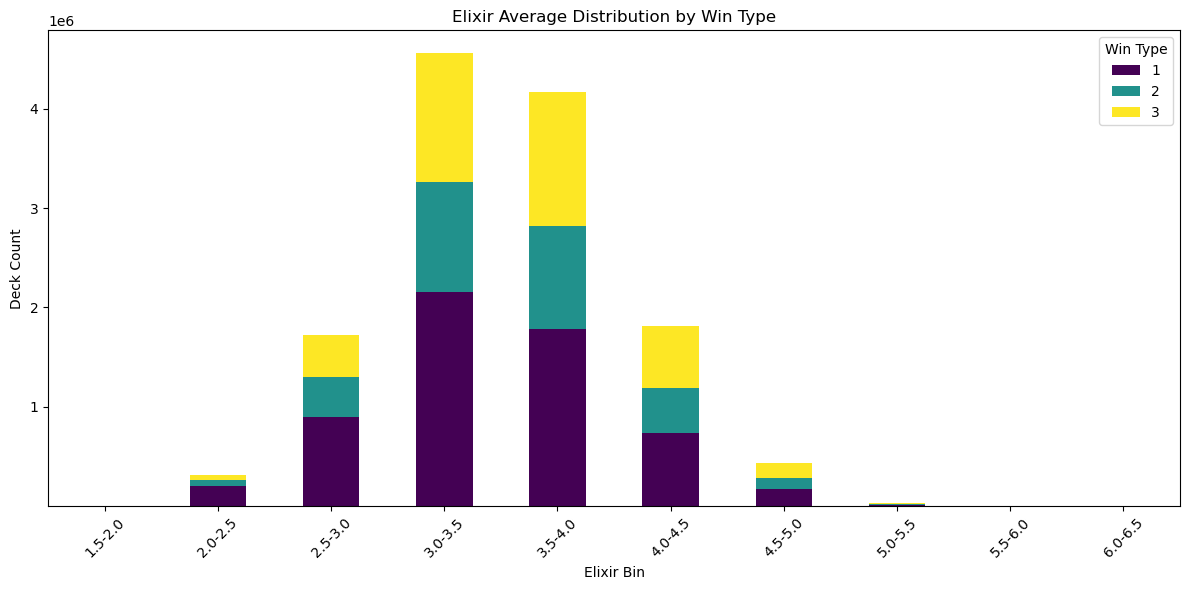

In [8]:
# ---------------------------------------------------------
# B2 — Plot using the aggregated table (fast)
# ---------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

elixir_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="viridis"
)

plt.title("Elixir Average Distribution by Win Type")
plt.xlabel("Elixir Bin")
plt.ylabel("Deck Count")
plt.xticks(rotation=45)
plt.legend(title="Win Type")
plt.tight_layout()
plt.show()




In [9]:
# ---------------------------------------------------------
# C1 — Build trophy bins
# ---------------------------------------------------------

import numpy as np

bin_width = 400

trophy_min = master["winner.startingTrophies"].min()
trophy_max = master["winner.startingTrophies"].max()

trophy_bins = np.arange(
    trophy_min - (trophy_min % bin_width),
    trophy_max + bin_width,
    bin_width
)

trophy_labels = [f"{b}-{b+bin_width}" for b in trophy_bins[:-1]]

master["trophy_bin"] = pd.cut(
    master["winner.startingTrophies"],
    bins=trophy_bins,
    labels=trophy_labels,
    include_lowest=True
)



In [10]:
# ---------------------------------------------------------
# C2 — Trophy distribution by win_type
# ---------------------------------------------------------


trophy_dist = (
    master.groupby(["win_type", "trophy_bin"], observed=True)
          .size()
          .unstack("win_type")
          .fillna(0)
          .astype("int32")
          .sort_index()
)

print(trophy_dist.head(10))



win_type            1      2       3
trophy_bin                          
0.0-400.0        2985   4524   25985
400.0-800.0      3892   5110   28678
800.0-1200.0    12665  13565   51895
1200.0-1600.0    6677   5555   26535
1600.0-2000.0   24291  22084   55227
2000.0-2400.0    8788   7535   37092
2400.0-2800.0   10273   8129   38277
2800.0-3200.0   11455   8486   43651
3200.0-3600.0   26240  18617   66554
3600.0-4000.0  114225  89604  187547


In [11]:
# ---------------------------------------------------------
# C3 — Percentage distribution by win_type
# ---------------------------------------------------------

trophy_dist_pct = (
    trophy_dist.div(trophy_dist.sum(axis=0), axis=1) * 100
).round(2)

print(trophy_dist_pct.head(10))



win_type          1     2     3
trophy_bin                     
0.0-400.0      0.04  0.11  0.52
400.0-800.0    0.05  0.12  0.57
800.0-1200.0   0.17  0.33  1.03
1200.0-1600.0  0.09  0.13  0.53
1600.0-2000.0  0.32  0.53  1.10
2000.0-2400.0  0.12  0.18  0.74
2400.0-2800.0  0.13  0.20  0.76
2800.0-3200.0  0.15  0.21  0.87
3200.0-3600.0  0.34  0.45  1.32
3600.0-4000.0  1.50  2.17  3.73


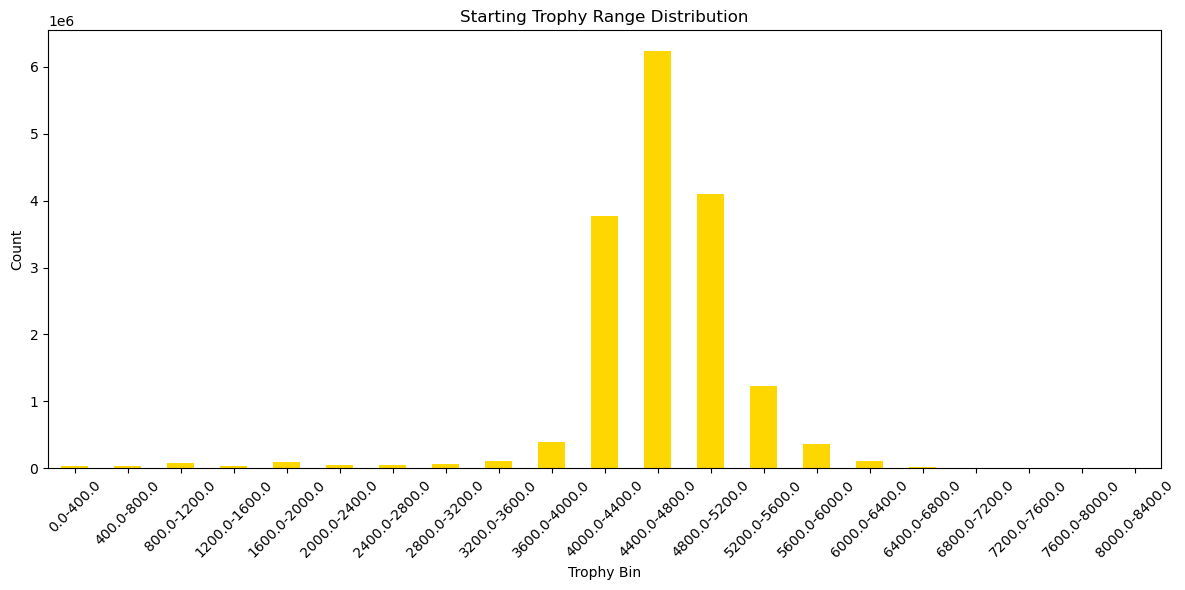

In [115]:
trophy_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="viridis"
)

plt.title("Starting Trophy Range Distribution by Win Type")
plt.xlabel("Trophy Bin")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Win Type")
plt.tight_layout()
plt.show()


_____

***Step 3 - Card Synergy Data***

_____

In [13]:
# ---------------------------------------------------------
# STEP 3A — Load MASTER parquet
# ---------------------------------------------------------

import pandas as pd
import time
from datetime import datetime
from tqdm.notebook import tqdm

tA = time.time()
print(f"[{datetime.now().strftime('%H:%M:%S')}] STEP 3A — Loading MASTER parquet...")

df = pd.read_parquet(master_path)

print(f"[{datetime.now().strftime('%H:%M:%S')}] Loaded MASTER:")
print(f" → Rows: {len(df):,}")
print(f" → Columns: {len(df.columns)}")
print(f"Completed STEP 3A in {time.time() - tA:.2f} sec.\n")


[16:10:43] STEP 3A — Loading MASTER parquet...
[16:11:03] Loaded MASTER:
 → Rows: 16,795,959
 → Columns: 34
Completed STEP 3A in 19.87 sec.



In [14]:
# ---------------------------------------------------------
# STEP 3B — Build deck_list
# ---------------------------------------------------------

tB = time.time()
print(f"[{datetime.now().strftime('%H:%M:%S')}] STEP 3B — Building deck_list...")

winner_card_cols = [f"winner.card{i}.id" for i in range(1, 9)]

missing_cards = [c for c in winner_card_cols if c not in df.columns]
if missing_cards:
    raise KeyError(f"Missing winner card columns: {missing_cards}")

df["deck_list"] = df[winner_card_cols].values.tolist()

print(f"[{datetime.now().strftime('%H:%M:%S')}] ✓ deck_list created.")
print(df["deck_list"].head())

print(f"Completed STEP 3B in {time.time() - tB:.2f} sec.\n")


[16:11:07] STEP 3B — Building deck_list...
[16:11:16] ✓ deck_list created.
0    [26000036, 28000015, 26000050, 26000044, 26000...
1    [26000022, 26000012, 26000043, 26000024, 26000...
2    [26000004, 26000042, 28000009, 26000036, 26000...
3    [26000004, 26000006, 26000007, 26000011, 26000...
4    [28000004, 28000008, 26000004, 26000013, 26000...
Name: deck_list, dtype: object
Completed STEP 3B in 8.93 sec.



In [15]:
# ---------------------------------------------------------
# STEP 3C — Apply filtering rules
# ---------------------------------------------------------

tC = time.time()
print(f"[{datetime.now().strftime('%H:%M:%S')}] STEP 3C — Applying all filters...")

df_f = df.copy()

df_f = df_f[
    (df_f["winner.startingTrophies"] >= 4000) &
    (df_f["winner.startingTrophies"] <= 5800) &
    (df_f["winner.elixir.average"] >= 2.5) &
    (df_f["winner.elixir.average"] <= 4.5) &
    (df_f["winner.crowns"].isin([1, 2, 3]))
].copy()

df_f = df_f.rename(columns={"winner.crowns": "win_type"})

print(f"[{datetime.now().strftime('%H:%M:%S')}] ✓ Filters applied.")
print(f"Remaining rows: {len(df_f):,}")
print(f"[{datetime.now().strftime('%H:%M:%S')}] STEP 3C completed in {time.time() - tC:.2f} sec.\n")


[16:11:29] STEP 3C — Applying all filters...
[16:11:48] ✓ Filters applied.
Remaining rows: 14,203,422
[16:11:48] STEP 3C completed in 19.53 sec.



In [16]:
!pip install tqdm

# ---------------------------------------------------------
# 3D-A — Load MASTER + basic diagnostics
# ---------------------------------------------------------
import pandas as pd
from datetime import datetime
import time

print(f"[{datetime.now().strftime('%H:%M:%S')}] 3D-A — Loading MASTER parquet...")

df = pd.read_parquet(master_path)

print(f"[{datetime.now().strftime('%H:%M:%S')}] Loaded: {len(df):,} rows")
print("Columns:")
print(df.columns.tolist())



[16:12:18] Loaded: 16,795,959 rows
Columns:
['Unnamed: 0', 'battleTime', 'gameMode.id', 'average.startingTrophies', 'winner.tag', 'winner.startingTrophies', 'winner.trophyChange', 'winner.crowns', 'winner.card1.id', 'winner.card1.level', 'winner.card2.id', 'winner.card2.level', 'winner.card3.id', 'winner.card3.level', 'winner.card4.id', 'winner.card4.level', 'winner.card5.id', 'winner.card5.level', 'winner.card6.id', 'winner.card6.level', 'winner.card7.id', 'winner.card7.level', 'winner.card8.id', 'winner.card8.level', 'winner.cards.list', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 'winner.elixir.average']


In [17]:
!pip install tqdm

# ---------------------------------------------------------
# 3D-B — Build deck_list + apply filters
# ---------------------------------------------------------
import numpy as np

card_cols = [f"winner.card{i}.id" for i in range(1, 9)]
missing = [c for c in card_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing card columns: {missing}")

print("✓ card columns found")

df["deck_list"] = df[card_cols].values.tolist()
print("✓ deck_list created")

df_f = df[
    (df["winner.startingTrophies"] >= 4000) &
    (df["winner.startingTrophies"] <= 5800) &
    (df["winner.elixir.average"] >= 2.5) &
    (df["winner.elixir.average"] <= 4.5) &
    (df["winner.crowns"].isin([1, 2, 3]))
].copy()

df_f = df_f.rename(columns={"winner.crowns": "win_type"})

print(f"✓ Filtering complete → {len(df_f):,} rows remain")


✓ card columns found
✓ deck_list created
✓ Filtering complete → 14,203,422 rows remain


In [18]:
!pip install tqdm

# ---------------------------------------------------------
# 3D-C — Create elixir_bin + distribution check
# ---------------------------------------------------------

elixir_bins = np.arange(2.0, 5.5, 0.5)
elixir_labels = [f"{elixir_bins[i]:.1f}-{elixir_bins[i+1]:.1f}" for i in range(len(elixir_bins)-1)]

df_f["elixir_bin"] = pd.cut(
    df_f["winner.elixir.average"],
    bins=elixir_bins,
    labels=elixir_labels,
    include_lowest=True
)

df_f = df_f.dropna(subset=["elixir_bin"])

print("✓ elixir_bin created\n")

print("Elixir_bin × win_type distribution:")
print(df_f.groupby(["elixir_bin", "win_type"]).size())


✓ elixir_bin created

Elixir_bin × win_type distribution:


C:\Users\peter\AppData\Local\Temp\ipykernel_692\2228635869.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_f.groupby(["elixir_bin", "win_type"]).size())


elixir_bin  win_type
2.0-2.5     1.0           11379
            2.0            3739
            3.0            3020
2.5-3.0     1.0          599516
            2.0          161048
            3.0          131624
3.0-3.5     1.0         1566993
            2.0          694453
            3.0          664258
3.5-4.0     1.0         2907655
            2.0         1651328
            3.0         1815669
4.0-4.5     1.0         1668062
            2.0         1036308
            3.0         1288370
4.5-5.0     1.0               0
            2.0               0
            3.0               0
dtype: int64


In [19]:
!pip install tqdm

# ---------------------------------------------------------
# 3D-D — Stratified sampling (elixir_bin × win_type)
# ---------------------------------------------------------

import time

SAMPLE_PER_GROUP = 3000
group_cols = ["elixir_bin", "win_type"]

print("Counts before sampling:")
print(df_f.groupby(group_cols).size())

def do_sample(g):
    n = min(SAMPLE_PER_GROUP, len(g))
    return g.sample(n=n, random_state=42)

df_sample = (
    df_f
    .groupby(group_cols, group_keys=True)
    .apply(do_sample)
    .reset_index(drop=True)
)

print(f"\n✓ Sampling complete → {len(df_sample):,} rows")

print("\nCounts after sampling:")
print(df_sample.groupby(group_cols).size())


Counts before sampling:


C:\Users\peter\AppData\Local\Temp\ipykernel_692\2686135874.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_f.groupby(group_cols).size())


elixir_bin  win_type
2.0-2.5     1.0           11379
            2.0            3739
            3.0            3020
2.5-3.0     1.0          599516
            2.0          161048
            3.0          131624
3.0-3.5     1.0         1566993
            2.0          694453
            3.0          664258
3.5-4.0     1.0         2907655
            2.0         1651328
            3.0         1815669
4.0-4.5     1.0         1668062
            2.0         1036308
            3.0         1288370
4.5-5.0     1.0               0
            2.0               0
            3.0               0
dtype: int64


C:\Users\peter\AppData\Local\Temp\ipykernel_692\2686135874.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_cols, group_keys=True)



✓ Sampling complete → 45,000 rows

Counts after sampling:
elixir_bin  win_type
2.0-2.5     1.0         3000
            2.0         3000
            3.0         3000
2.5-3.0     1.0         3000
            2.0         3000
            3.0         3000
3.0-3.5     1.0         3000
            2.0         3000
            3.0         3000
3.5-4.0     1.0         3000
            2.0         3000
            3.0         3000
4.0-4.5     1.0         3000
            2.0         3000
            3.0         3000
4.5-5.0     1.0            0
            2.0            0
            3.0            0
dtype: int64


C:\Users\peter\AppData\Local\Temp\ipykernel_692\2686135874.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(do_sample)
C:\Users\peter\AppData\Local\Temp\ipykernel_692\2686135874.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_sample.groupby(group_cols).size())


In [20]:
!pip install tqdm

# ---------------------------------------------------------
# 3D-E — 3-card core extraction (B3 Phase 1 only)
# ---------------------------------------------------------

from itertools import combinations
from tqdm.notebook import tqdm
from collections import Counter

MIN_FREQ = 100
core3_counter = Counter()

print("Extracting 3-card combos...")

for deck in tqdm(df_sample["deck_list"], unit="deck"):
    d = sorted(deck)
    for c in combinations(d, 3):
        core3_counter[c] += 1

print(f"✓ Counting done → {len(core3_counter):,} unique combos")

# Filter combos
filtered = [(combo, c) for combo, c in core3_counter.items() if c >= MIN_FREQ]

print(f"✓ combos ≥ {MIN_FREQ}: {len(filtered):,}")

core3_df = pd.DataFrame(
    [(c[0], c[1], c[2], count) for c, count in filtered],
    columns=["card1", "card2", "card3", "count"]
).sort_values("count", ascending=False).reset_index(drop=True)

print("Top 10 cores:")
print(core3_df.head(10))

# Save file
output_path = "candidate_core3_top100.parquet"
core3_df.to_parquet(output_path, index=False)

print(f"✓ Saved → {output_path}")


Extracting 3-card combos...


  0%|          | 0/45000 [00:00<?, ?deck/s]

✓ Counting done → 114,680 unique combos
✓ combos ≥ 100: 4,437
Top 10 cores:
      card1     card2     card3  count
0  26000010  26000030  28000011   4923
1  26000000  26000010  28000011   4705
2  26000000  28000004  28000011   4121
3  26000010  26000021  28000011   3554
4  26000010  26000038  28000011   3552
5  26000010  28000000  28000011   3491
6  26000021  26000030  28000011   3313
7  26000000  27000004  28000011   3310
8  26000000  26000030  28000011   3211
9  26000030  28000000  28000011   3173
✓ Saved → candidate_core3_top100.parquet


Counting weighted card frequencies:   0%|          | 0/4437 [00:00<?, ?it/s]

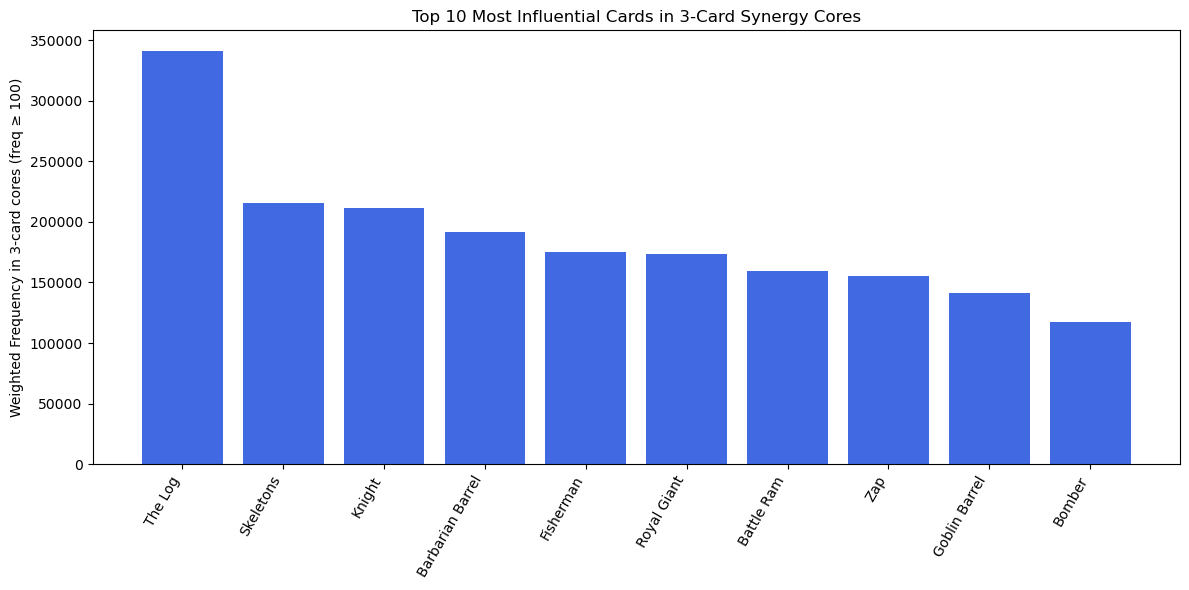

In [21]:
!pip install tqdm

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm

# enable inline plots
%matplotlib inline

# ---------------------------------------------------------
# Build id → name lookup
# ---------------------------------------------------------
id_to_name = {
    26000000: "Knight",
    26000001: "Archers",
    26000002: "Goblins",
    26000003: "Giant",
    26000004: "P.E.K.K.A",
    26000005: "Minions",
    26000006: "Balloon",
    26000007: "Witch",
    26000008: "Golem",
    26000009: "Valkyrie",
    26000010: "Skeletons",
    26000011: "Bomber",
    26000012: "Musketeer",
    26000013: "Baby Dragon",
    26000014: "Prince",
    26000015: "Wizard",
    26000016: "Mini P.E.K.K.A",
    26000017: "Spear Goblins",
    26000018: "Giant Skeleton",
    26000019: "Hog Rider",
    26000020: "Ice Wizard",
    26000021: "Royal Giant",
    26000022: "Minion Horde",
    26000023: "Lava Hound",
    26000024: "Ice Golem",
    26000025: "Guards",
    26000026: "Princess",
    26000027: "Three Musketeers",
    26000028: "Bowler",
    26000029: "Lumberjack",
    26000030: "Battle Ram",
    26000031: "Fire Spirits",
    26000032: "Ice Spirit",
    26000033: "Elite Barbarians",
    26000034: "Dart Goblin",
    26000035: "Executioner",
    26000036: "Bandit",
    26000037: "Royal Ghost",
    26000038: "Bats",
    26000039: "Zappies",
    26000040: "Hunter",
    26000041: "Night Witch",
    26000042: "Cannon Cart",
    26000043: "Mega Knight",
    26000044: "Skeleton Barrel",
    26000045: "Flying Machine",
    26000046: "Wall Breakers",
    26000047: "Royal Hogs",
    26000048: "Goblin Giant",
    26000049: "Fisherman",
    26000050: "Magic Archer",
    26000051: "Electro Dragon",
    26000052: "Firecracker",
    26000053: "Electro Spirit",
    26000054: "Heal Spirit",
    26000055: "Skeleton Dragons",
    26000056: "Electro Giant",
    26000057: "Mother Witch",
    26000058: "Elite Archer",
    26000059: "Mighty Miner",
    26000060: "Archer Queen",
    26000061: "Golden Knight",
    26000062: "Skeleton King",
    27000000: "Cannon",
    27000001: "Goblin Hut",
    27000002: "Mortar",
    27000003: "Inferno Tower",
    27000004: "Bomb Tower",
    27000005: "Barbarian Hut",
    27000006: "Tesla",
    27000007: "Elixir Collector",
    27000008: "X-Bow",
    27000009: "Tombstone",
    27000010: "Furnace",
    27000011: "Goblin Cage",
    28000000: "Zap",
    28000001: "Arrows",
    28000002: "Rage",
    28000003: "Rocket",
    28000004: "Goblin Barrel",
    28000005: "Freeze",
    28000006: "Mirror",
    28000007: "Lightning",
    28000008: "Barbarian Barrel",
    28000009: "Poison",
    28000010: "Tornado",
    28000011: "The Log",
    28000012: "Clone",
    28000013: "Earthquake",
    28000014: "Royal Delivery",
    28000015: "Giant Snowball",
    29000000: "Archer Queen",
    29000001: "Golden Knight",
    29000002: "Skeleton King",
    29000003: "Monk",
}

# ---------------------------------------------------------
# Load 3-card core file
# ---------------------------------------------------------
core3_df = pd.read_parquet("candidate_core3_top100.parquet")

# ---------------------------------------------------------
# Count weighted frequencies
# ---------------------------------------------------------
counter = Counter()

for row in tqdm(core3_df.itertuples(index=False),
                total=len(core3_df),
                desc="Counting weighted card frequencies"):
    counter[row.card1] += row.count
    counter[row.card2] += row.count
    counter[row.card3] += row.count

df_freq = (
    pd.DataFrame(list(counter.items()), columns=["card_id", "freq"])
    .sort_values("freq", ascending=False)
)

df_freq["card_name"] = df_freq["card_id"].map(id_to_name)

# ---------------------------------------------------------
# Plot top 10
# ---------------------------------------------------------
top10 = df_freq.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10["card_name"], top10["freq"], color="royalblue")

plt.xticks(rotation=60, ha="right")
plt.ylabel("Weighted Frequency in 3-card cores (freq ≥ 100)")
plt.title("Top 10 Most Influential Cards in 3-Card Synergy Cores")

plt.tight_layout()
plt.show()


In [54]:
# ---------------------------------------------------------
# RESET id_to_name (must be a DICTIONARY, NOT a set!)
# ---------------------------------------------------------

id_to_name = {
    26000000: "Knight", 26000001: "Archers", 26000002: "Goblins",
    26000003: "Giant", 26000004: "P.E.K.K.A", 26000005: "Minions",
    26000006: "Balloon", 26000007: "Witch", 26000008: "Golem",
    26000009: "Valkyrie", 26000010: "Skeletons", 26000011: "Bomber",
    26000012: "Musketeer", 26000013: "Baby Dragon", 26000014: "Prince",
    26000015: "Wizard", 26000016: "Mini P.E.K.K.A", 26000017: "Spear Goblins",
    26000018: "Giant Skeleton", 26000019: "Hog Rider", 26000020: "Ice Wizard",
    26000021: "Royal Giant", 26000022: "Minion Horde", 26000023: "Lava Hound",
    26000024: "Ice Golem", 26000025: "Guards", 26000026: "Princess",
    26000027: "Three Musketeers", 26000028: "Bowler", 26000029: "Lumberjack",
    26000030: "Battle Ram", 26000031: "Fire Spirits", 26000032: "Ice Spirit",
    26000033: "Elite Barbarians", 26000034: "Dart Goblin", 26000035: "Executioner",
    26000036: "Bandit", 26000037: "Royal Ghost", 26000038: "Bats",
    26000039: "Zappies", 26000040: "Hunter", 26000041: "Night Witch",
    26000042: "Cannon Cart", 26000043: "Mega Knight", 26000044: "Skeleton Barrel",
    26000045: "Flying Machine", 26000046: "Wall Breakers", 26000047: "Royal Hogs",
    26000048: "Goblin Giant", 26000049: "Fisherman", 26000050: "Magic Archer",
    26000051: "Electro Dragon", 26000052: "Firecracker", 26000053: "Electro Spirit",
    26000054: "Heal Spirit", 26000055: "Skeleton Dragons", 26000056: "Electro Giant",
    26000057: "Mother Witch", 26000058: "Elite Archer", 26000059: "Mighty Miner",
    26000060: "Archer Queen", 26000061: "Golden Knight", 26000062: "Skeleton King",
    27000000: "Cannon", 27000001: "Goblin Hut", 27000002: "Mortar",
    27000003: "Inferno Tower", 27000004: "Bomb Tower", 27000005: "Barbarian Hut",
    27000006: "Tesla", 27000007: "Elixir Collector", 27000008: "X-Bow",
    27000009: "Tombstone", 27000010: "Furnace", 27000011: "Goblin Cage",
    28000000: "Zap", 28000001: "Arrows", 28000002: "Rage", 28000003: "Rocket",
    28000004: "Goblin Barrel", 28000005: "Freeze", 28000006: "Mirror",
    28000007: "Lightning", 28000008: "Barbarian Barrel", 28000009: "Poison",
    28000010: "Tornado", 28000011: "The Log", 28000012: "Clone",
    28000013: "Earthquake", 28000014: "Royal Delivery", 28000015: "Giant Snowball",
    29000000: "Archer Queen", 29000001: "Golden Knight",
    29000002: "Skeleton King", 29000003: "Monk"
}


Counting card frequencies...


Card freq: 0it [00:00, ?it/s]


Top 10 card IDs: [28000011, 26000010, 26000000, 28000008, 26000049, 26000021, 26000030, 28000000, 28000004, 26000011]

Building pair synergy matrix...


Pair matrix:   0%|          | 0/4437 [00:00<?, ?it/s]

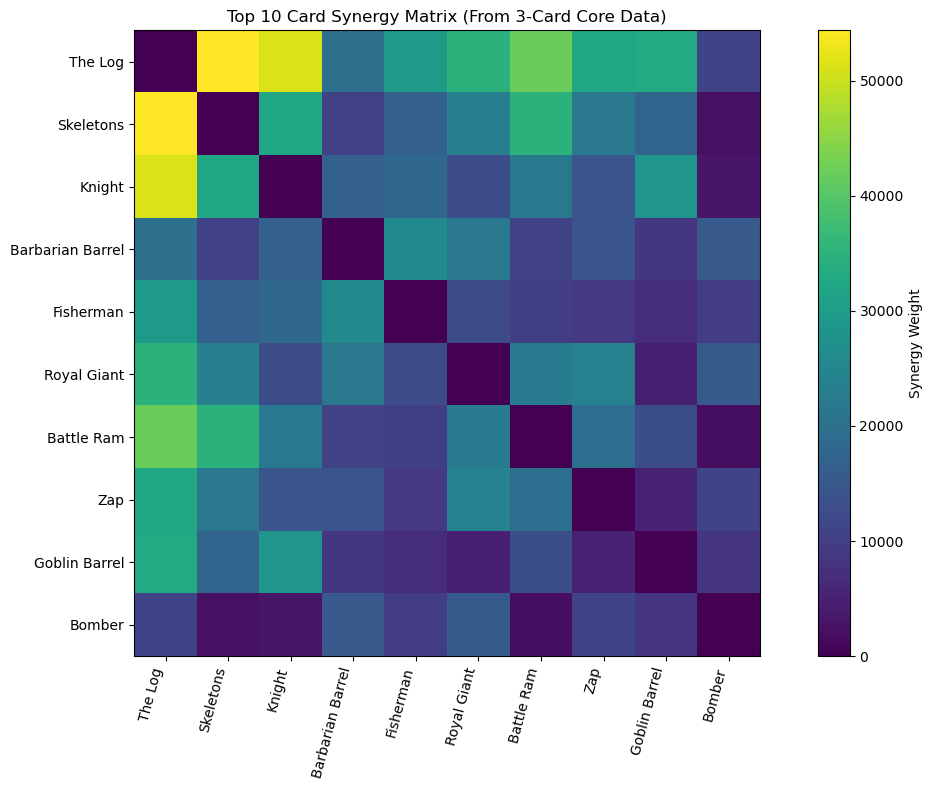

In [55]:
!pip install tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline


# =========================================================
# 1. Load Data
# =========================================================
core3 = pd.read_parquet("candidate_core3_top100.parquet")


# =========================================================
# 2. Identify Top 10 Cards (frequency-weighted)
# =========================================================
from collections import Counter

card_counter = Counter()

print("Counting card frequencies...")

for row in tqdm(core3.itertuples(index=False), desc="Card freq"):
    card_counter[row.card1] += row.count
    card_counter[row.card2] += row.count
    card_counter[row.card3] += row.count

card_freq = (
    pd.DataFrame(list(card_counter.items()), columns=["card_id", "freq"])
      .sort_values("freq", ascending=False)
      .reset_index(drop=True)
)

# Clean + guarantee list behavior
top_cards = (
    card_freq.head(10)["card_id"]
    .astype(int)     # ensure integer
    .tolist()
)

print("\nTop 10 card IDs:", top_cards)


# =========================================================
# 3. Pair Frequencies (Top 10 only)
# =========================================================
matrix = np.zeros((10, 10), dtype=int)

print("\nBuilding pair synergy matrix...")

for row in tqdm(core3.itertuples(index=False), total=len(core3), desc="Pair matrix"):
    cards = [row.card1, row.card2, row.card3]
    w = int(row.count)

    # Only count pairs where both cards are in the top 10
    for i in range(3):
        for j in range(i + 1, 3):
            a, b = cards[i], cards[j]
            if a in top_cards and b in top_cards:
                ia = top_cards.index(a)
                ib = top_cards.index(b)
                matrix[ia, ib] += w
                matrix[ib, ia] += w   # symmetric


# =========================================================
# 4. ID → Name converter (safe)
# =========================================================
def safe_name(cid):
    """If card name missing → return Unknown_<id>."""
    return id_to_name.get(cid, f"Unknown_{cid}")

labels = [safe_name(c) for c in top_cards]


# =========================================================
# 5. Plot Heatmap
# =========================================================
plt.figure(figsize=(12, 8))
plt.imshow(matrix, cmap="viridis")
plt.colorbar(label="Synergy Weight")

plt.xticks(range(10), labels, rotation=75, ha="right")
plt.yticks(range(10), labels)

plt.title("Top 10 Card Synergy Matrix (From 3-Card Core Data)")
plt.tight_layout()
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

Building Sankey links...


  0%|          | 0/10 [00:00<?, ?it/s]

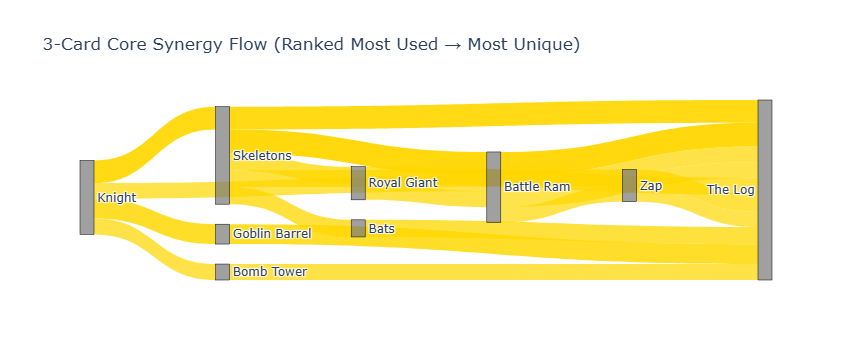

In [58]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# ================================
# Load 3-card core dataset
# ================================
core3 = pd.read_parquet("candidate_core3_top100.parquet")

# Take top 10 cores
topN = 10
core_top = core3.head(topN).copy()

# ================================
# Convert each core into sorted tuple (A,B,C)
# ================================
core_top["sorted"] = core_top.apply(
    lambda r: tuple(sorted([r.card1, r.card2, r.card3])),
    axis=1
)

# Map IDs → names
def safe_name(cid):
    return id_to_name.get(cid, f"Unknown_{cid}")

core_top["A"] = core_top["sorted"].apply(lambda x: safe_name(x[0]))
core_top["B"] = core_top["sorted"].apply(lambda x: safe_name(x[1]))
core_top["C"] = core_top["sorted"].apply(lambda x: safe_name(x[2]))

# ================================
# Compute overall card usage freq
# ================================
freq_counter = {}

for row in tqdm(core_top.itertuples(), total=len(core_top)):
    for cid in row.sorted:
        freq_counter[cid] = freq_counter.get(cid, 0) + row.count

# Convert to sorted ranking
freq_rank = {
    cid: rank
    for rank, (cid, _) in enumerate(
        sorted(freq_counter.items(), key=lambda x: -x[1])
    )
}

# Normalize ranks into Lanes (0 = most common)
# Only 3 lanes: 0 (meta), 1 (mid), 2 (unique)
cid_to_lane = {
    cid: min(freq_rank[cid] // 3, 2)
    for cid in freq_rank
}

# ================================
# Build node list
# ================================
nodes = sorted({safe_name(cid) for cid in freq_counter})
node_index = {name: i for i, name in enumerate(nodes)}

# Assign lanes for plotting order
lane_position = {
    safe_name(cid): cid_to_lane[cid] for cid in freq_counter
}

# Node x-position (forces structure)
node_xpos = [lane_position[name] * 0.33 for name in nodes]

# ================================
# Build Sankey Links
# ================================
sources = []
targets = []
values = []

print("Building Sankey links...")
for r in tqdm(core_top.itertuples(), total=len(core_top)):

    A, B, C = r.A, r.B, r.C
    w = r.count

    sources.append(node_index[A])  
    targets.append(node_index[B])
    values.append(w)

    sources.append(node_index[B])
    targets.append(node_index[C])
    values.append(w)

# ================================
# Plot Sankey (ranked left → right)
# ================================
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    
    node=dict(
        pad=20,
        thickness=14,
        line=dict(color="black", width=0.5),
        label=nodes,
        x=node_xpos,
        color="rgba(120, 120, 120, 0.7)"
    ),
    
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[
            f"rgba(255, 215, 0,{0.25 + 0.7*(v/max(values))})"
            for v in values
        ]
    )
)])

fig.update_layout(
    title_text="3-Card Core Synergy Flow (Ranked Most Used → Most Unique)",
    font_size=12,
    plot_bgcolor="white"
)

fig.show()


In [59]:
!pip install tqdm plotly networkx

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import networkx as nx

# ---------------------------------------
# Load top 3-card cores
# ---------------------------------------
core3 = pd.read_parquet("candidate_core3_top100.parquet")

topN = 10  # you can bump this later if it behaves well
core_top = core3.head(topN).copy()

# ---------------------------------------
# Safe ID → Name lookup
# (assumes id_to_name dict already defined above)
# ---------------------------------------
def safe_name(cid):
    return id_to_name.get(cid, f"Unknown_{cid}")

# Sort each core’s IDs so (A,B,C) is consistent
core_top["sorted"] = core_top.apply(
    lambda r: tuple(sorted([r.card1, r.card2, r.card3])),
    axis=1
)

core_top["A"] = core_top["sorted"].apply(lambda x: safe_name(x[0]))
core_top["B"] = core_top["sorted"].apply(lambda x: safe_name(x[1]))
core_top["C"] = core_top["sorted"].apply(lambda x: safe_name(x[2]))

# ---------------------------------------
# Build node list and link list
# ---------------------------------------
nodes = sorted(set(core_top["A"]) | set(core_top["B"]) | set(core_top["C"]))
node_index = {name: i for i, name in enumerate(nodes)}

sources = []
targets = []
values  = []

print("Building A→B and B→C links...")
for row in tqdm(core_top.itertuples(index=False), total=len(core_top), desc="Links"):
    A, B, C, w = row.A, row.B, row.C, int(row.count)

    # A → B
    sources.append(node_index[A])
    targets.append(node_index[B])
    values.append(w)

    # B → C
    sources.append(node_index[B])
    targets.append(node_index[C])
    values.append(w)

# ---------------------------------------
# Compute card frequency across all cores
# ---------------------------------------
from collections import Counter

card_freq = Counter()
print("Counting overall card frequency...")
for row in tqdm(core_top.itertuples(index=False), total=len(core_top), desc="Card freq"):
    for name in (row.A, row.B, row.C):
        card_freq[name] += int(row.count)

print("Done setup.")


Building A→B and B→C links...


Links:   0%|          | 0/10 [00:00<?, ?it/s]

Counting overall card frequency...


Card freq:   0%|          | 0/10 [00:00<?, ?it/s]

Done setup.


Computing 3D spring layout with higher repulsion…
Building edge coordinates...


  0%|          | 0/17 [00:00<?, ?it/s]

Building node coordinates & gradient colors...


  0%|          | 0/9 [00:00<?, ?it/s]

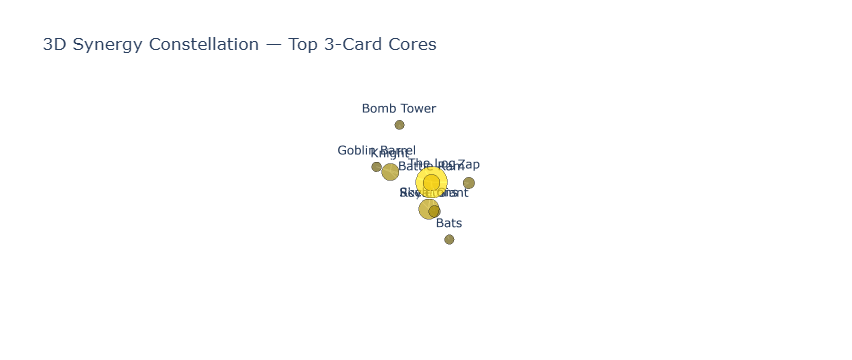

In [63]:
import numpy as np
import plotly.graph_objects as go
import networkx as nx
from tqdm.notebook import tqdm

# =====================================================
# 3D Force Layout (more spread → higher repulsion)
# =====================================================
print("Computing 3D spring layout with higher repulsion…")
pos3 = nx.spring_layout(
    G2,
    weight="weight",
    dim=3,
    seed=42,
    k=1.8,          # increase ideal distance → more spacing
    iterations=200  # more iterations → smoother layout
)

# =====================================================
# Build edge traces
# =====================================================
edge_x3 = []
edge_y3 = []
edge_z3 = []

print("Building edge coordinates...")
for u, v, data in tqdm(G2.edges(data=True), total=G2.number_of_edges()):
    x0, y0, z0 = pos3[u]
    x1, y1, z1 = pos3[v]
    edge_x3.extend([x0, x1, None])
    edge_y3.extend([y0, y1, None])
    edge_z3.extend([z0, z1, None])

edge_trace3 = go.Scatter3d(
    x=edge_x3,
    y=edge_y3,
    z=edge_z3,
    mode='lines',
    line=dict(color='rgba(130,130,130,0.35)', width=2),
    hoverinfo='none'
)

# =====================================================
# Build node traces (with gradient color)
# =====================================================
node_x3 = []
node_y3 = []
node_z3 = []
node_sizes3 = []
node_colors = []

max_freq = max(card_freq.values())

print("Building node coordinates & gradient colors...")
for name in tqdm(nodes):
    x, y, z = pos3[name]
    node_x3.append(x)
    node_y3.append(y)
    node_z3.append(z)

    # size scaled by frequency
    freq = card_freq.get(name, 1)
    node_sizes3.append(8 + 28 * (freq / max_freq))

    # gradient color: bright gold → darker gold
    # scale 0.3 to 1.0 brightness
    scale = 0.3 + 0.7 * (freq / max_freq)
    r = int(255 * scale)
    g = int(215 * scale)
    b = int(0   * scale)

    node_colors.append(f"rgba({r},{g},{b},0.95)")

node_trace3 = go.Scatter3d(
    x=node_x3,
    y=node_y3,
    z=node_z3,
    mode='markers+text',
    text=nodes,
    textposition='top center',
    marker=dict(
        size=node_sizes3,
        color=node_colors,
        line=dict(color='black', width=1),
    ),
    hoverinfo='text'
)

# =====================================================
# Final 3D plot
# =====================================================
fig_force3d = go.Figure(data=[edge_trace3, node_trace3])
fig_force3d.update_layout(
    title="3D Synergy Constellation — Top 3-Card Cores",
    showlegend=False,
    plot_bgcolor="white",
    scene=dict(
        xaxis=dict(showbackground=False, visible=False),
        yaxis=dict(showbackground=False, visible=False),
        zaxis=dict(showbackground=False, visible=False),
    ),
)

fig_force3d.show()


Computing average elixir per card...


Scanning matches:   0%|          | 0/2519380 [00:00<?, ?it/s]

✓ Average elixir computed for 0 cards
Building pair edges...


  0%|          | 0/10 [00:00<?, ?it/s]

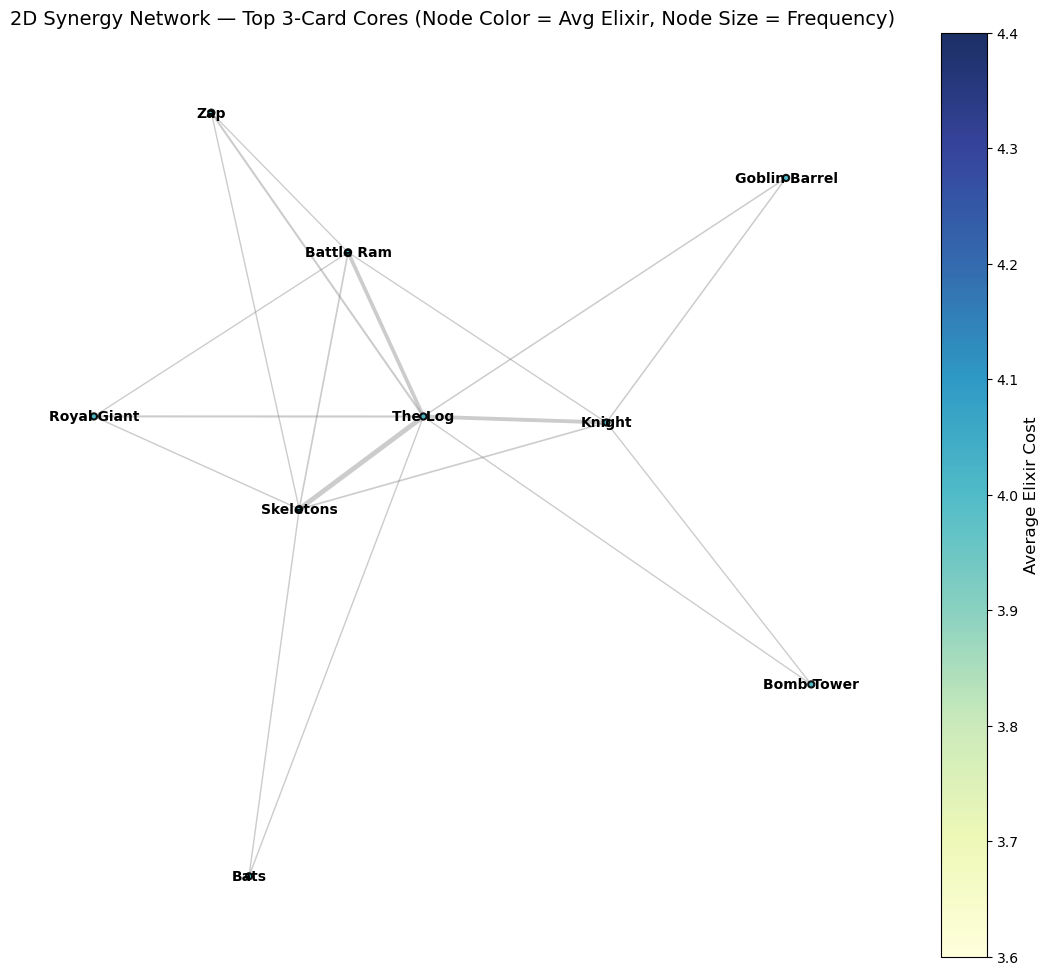

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np

# ---------------------------------------------------------
# 1. Compute Average Elixir per Card
# ---------------------------------------------------------
print("Computing average elixir per card...")

# List of (card, elixir) pairs
records = []

for row in tqdm(df_master_small.itertuples(index=False),
                total=len(df_master_small),
                desc="Scanning matches"):
    
    elix = getattr(row, "winner.elixir.average", None)
    if elix is None:
        continue

    # collect card IDs
    deck = [
        getattr(row, f"winner.card{i}.id", None)
        for i in range(1, 9)
    ]

    for cid in deck:
        if cid is not None:
            records.append((cid, elix))

elixir_df = pd.DataFrame(records, columns=["card_id", "elixir"])
avg_elixir = elixir_df.groupby("card_id")["elixir"].mean().to_dict()

print("✓ Average elixir computed for", len(avg_elixir), "cards")

# ---------------------------------------------------------
# 2. Build a synergy graph (only top 10 3-card cores)
# ---------------------------------------------------------
top10 = core3.head(10)  # top 10 cores

# Build weighted pair edges
pair_strength = {}

print("Building pair edges...")
for row in tqdm(top10.itertuples(index=False), total=len(top10)):
    cards = [row.card1, row.card2, row.card3]
    weight = row.count

    pairs = [
        tuple(sorted((cards[0], cards[1]))),
        tuple(sorted((cards[0], cards[2]))),
        tuple(sorted((cards[1], cards[2]))),
    ]

    for p in pairs:
        pair_strength[p] = pair_strength.get(p, 0) + weight

# Graph setup
G = nx.Graph()

# nodes
for cid in {c for pair in pair_strength.keys() for c in pair}:
    G.add_node(cid)

# edges
for (a, b), w in pair_strength.items():
    G.add_edge(a, b, weight=w)

# ---------------------------------------------------------
# 3. Map card IDs to names and metrics
# ---------------------------------------------------------
node_labels = {cid: id_to_name.get(cid, f"Unknown {cid}") for cid in G.nodes()}
node_sizes = [20 + 60 * (card_freq.get(cid, 1) / max(card_freq.values())) for cid in G.nodes()]
node_colors = [avg_elixir.get(cid, 4.0) for cid in G.nodes()]  # use elixir avg

# ---------------------------------------------------------
# 4. Layout & Plot
# ---------------------------------------------------------
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42, k=0.9, iterations=150)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="YlGnBu",    # yellow/green/blue for elixir
    alpha=0.92,
    linewidths=1.5,
    edgecolors="black"
)

edges = nx.draw_networkx_edges(
    G,
    pos,
    width=[0.5 + 3*(d["weight"]/max(pair_strength.values())) for _,_,d in G.edges(data=True)],
    edge_color="gray",
    alpha=0.4
)

nx.draw_networkx_labels(
    G,
    pos,
    labels=node_labels,
    font_size=10,
    font_weight="bold"
)

plt.title("2D Synergy Network — Top 3-Card Cores (Node Color = Avg Elixir, Node Size = Frequency)",
          fontsize=14)

cbar = plt.colorbar(nodes)
cbar.set_label("Average Elixir Cost", fontsize=12)

plt.axis("off")
plt.show()


Aggregating per-card:   0%|          | 0/4437 [00:00<?, ?it/s]

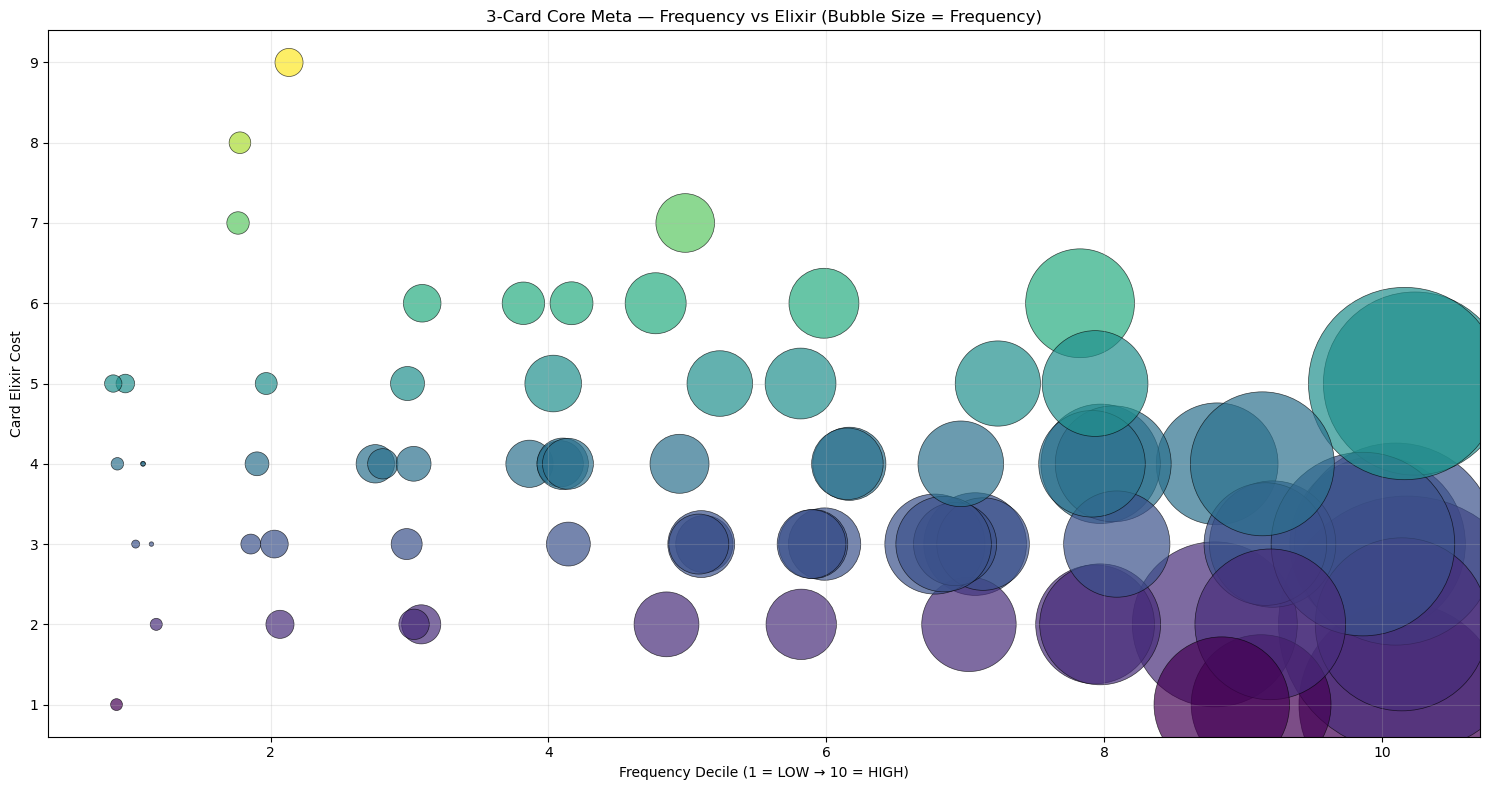

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------
core3 = pd.read_parquet("candidate_core3_top100.parquet")

# total per-card frequency across all 3-card cores
card_freq = {}

for row in tqdm(core3.itertuples(index=False), total=len(core3), desc="Aggregating per-card"):
    weight = row.count
    for cid in [row.card1, row.card2, row.card3]:
        card_freq[cid] = card_freq.get(cid, 0) + weight

cards_df = pd.DataFrame([
    (cid, freq) for cid, freq in card_freq.items()
], columns=["card_id", "freq"])

# Map elixir
cards_df["avg_elixir"] = cards_df["card_id"].map(id_to_elixir)
cards_df = cards_df.dropna(subset=["avg_elixir"]).reset_index(drop=True)


# ---------------------------------------------------------
# 2. SAFE DECILE BUCKETING (never fails)
# ---------------------------------------------------------
freq_vals = cards_df["freq"].values

if np.unique(freq_vals).size < 5:
    print("⚠️ freq has low variation → using rank-based decile bucketing")

    cards_df = cards_df.sort_values("freq", ascending=True).reset_index(drop=True)

    n = len(cards_df)
    cards_df["freq_decile"] = (
        (np.linspace(0, 1, n) * 10).astype(int) + 1
    ).clip(1, 10)

else:
    cards_df["freq_decile"] = pd.qcut(
        cards_df["freq"],
        q=10,
        labels=range(1, 11),
        duplicates="drop"
    ).astype(int)

# jitter for readability
rng = np.random.default_rng(42)
cards_df["x_jitter"] = cards_df["freq_decile"] + rng.uniform(-0.25, 0.25, len(cards_df))


# ---------------------------------------------------------
# COLORS BY ELIXIR BUCKET (1–10 hues)
# ---------------------------------------------------------
elixir_vals = cards_df["avg_elixir"].values
min_e, max_e = elixir_vals.min(), elixir_vals.max()

norm_elixir = (elixir_vals - min_e) / (max_e - min_e + 1e-9)
colors = plt.cm.viridis(norm_elixir)


# ---------------------------------------------------------
# 3. Bubble Plot
# ---------------------------------------------------------
plt.figure(figsize=(15, 8))

plt.scatter(
    cards_df["x_jitter"],
    cards_df["avg_elixir"],
    s=cards_df["freq"] * 0.10,    # bubble size scaled
    c=colors,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5
)

plt.xlabel("Frequency Decile (1 = LOW → 10 = HIGH)")
plt.ylabel("Card Elixir Cost")
plt.title("3-Card Core Meta — Frequency vs Elixir (Bubble Size = Frequency)")

plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


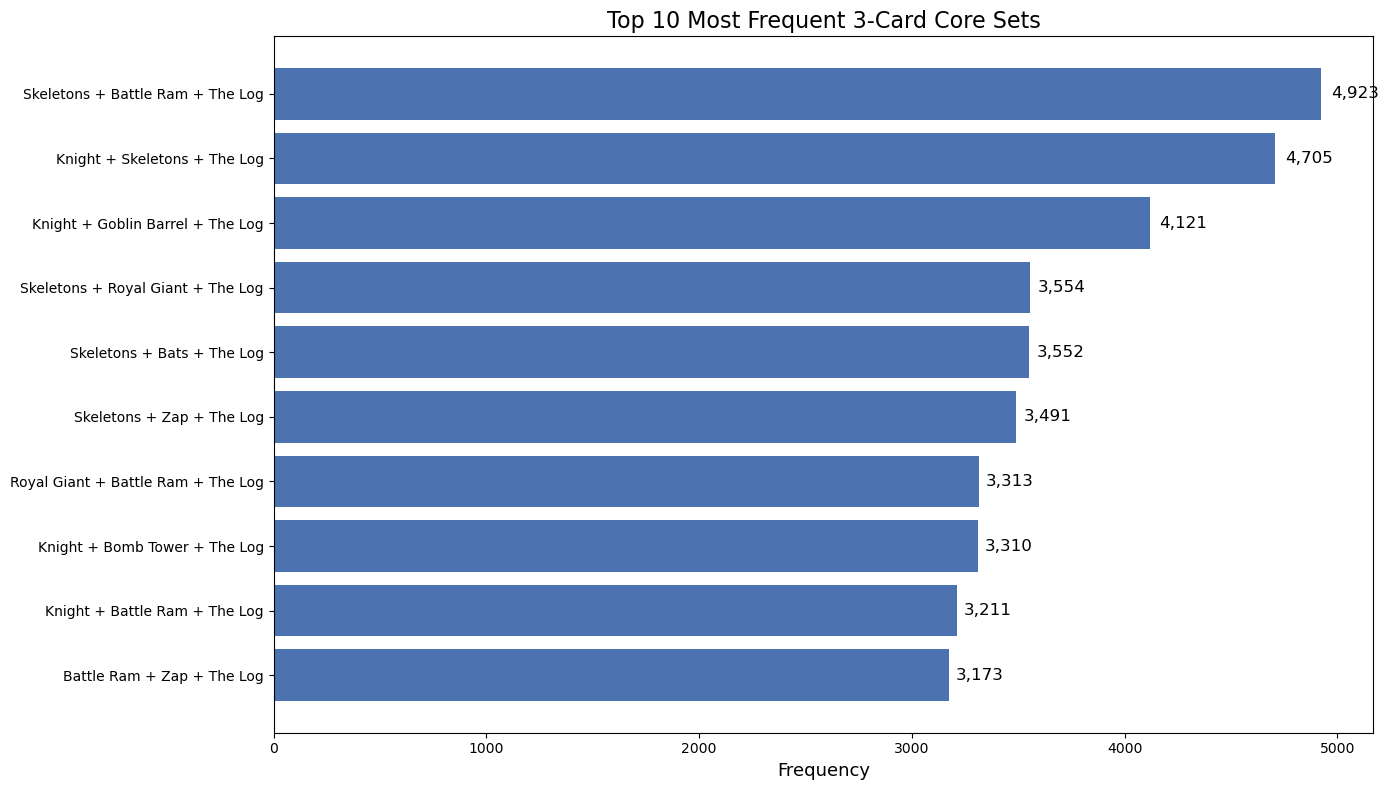

In [74]:
import matplotlib.pyplot as plt

# ----- Get top 10 -----
top10 = core3_df.head(10).copy()

# ----- Convert IDs → Names -----
def trio_label(row):
    a = id_to_name.get(row.card1, str(row.card1))
    b = id_to_name.get(row.card2, str(row.card2))
    c = id_to_name.get(row.card3, str(row.card3))
    return f"{a} + {b} + {c}"

top10["label"] = top10.apply(trio_label, axis=1)

# Reverse order for clean horizontal display
top10 = top10.iloc[::-1]

# ----- Plot -----
plt.figure(figsize=(14, 8))
plt.barh(top10["label"], top10["count"], color="#4C72B0")

plt.title("Top 10 Most Frequent 3-Card Core Sets", fontsize=16)
plt.xlabel("Frequency", fontsize=13)

# Add value labels on bars
for idx, v in enumerate(top10["count"]):
    plt.text(v + v*0.01, idx, f"{v:,}", va="center", fontsize=12)

plt.tight_layout()
plt.show()


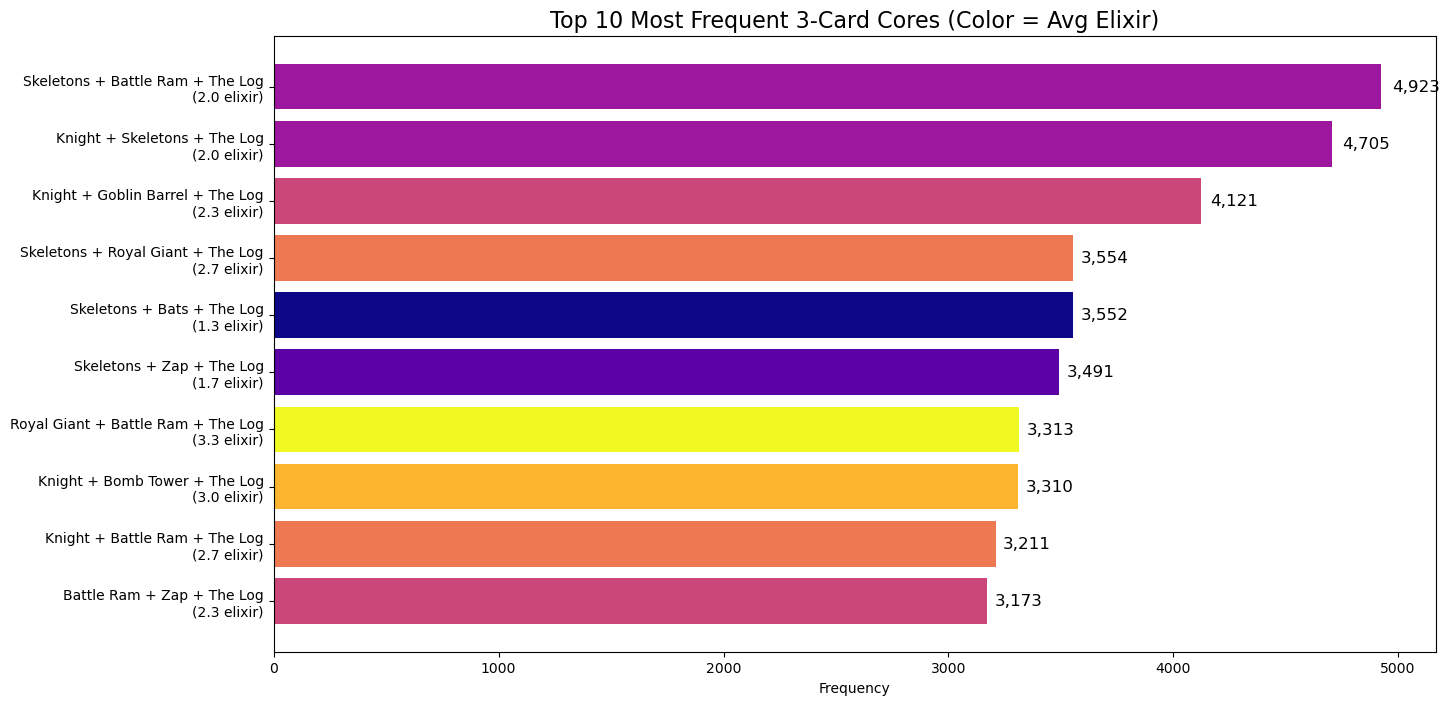

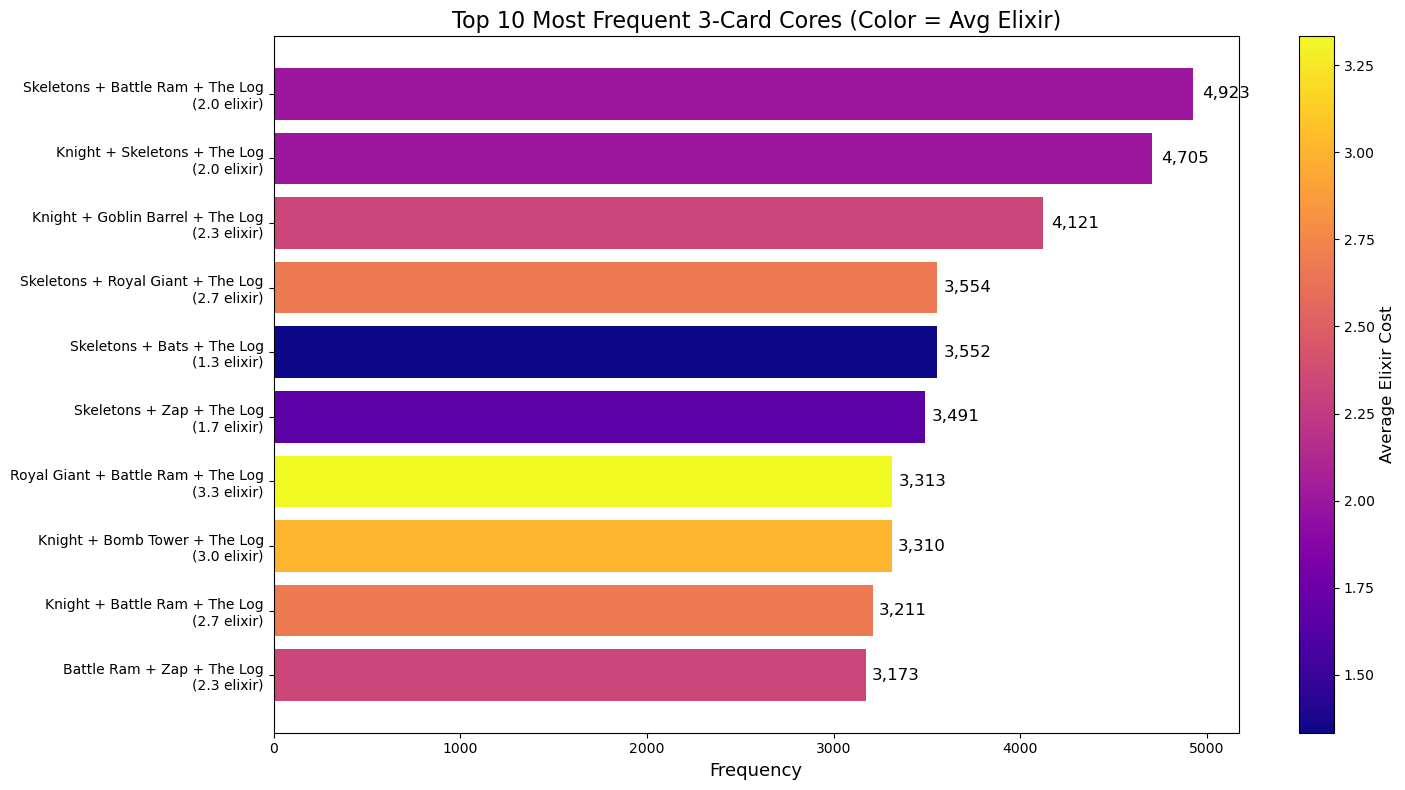

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Use your elixir lookup
# -----------------------------
card_elixir = id_to_elixir

# -----------------------------
# 2. Compute avg elixir
# -----------------------------
def compute_avg_elixir(row):
    costs = [
        card_elixir.get(row.card1),
        card_elixir.get(row.card2),
        card_elixir.get(row.card3)
    ]
    costs = [c for c in costs if c is not None]
    return sum(costs) / len(costs) if costs else np.nan

core3_df["avg_elixir"] = core3_df.apply(compute_avg_elixir, axis=1)

# -----------------------------
# 3. Top 10 by frequency
# -----------------------------
top10 = core3_df.nlargest(10, "count").copy()

# -----------------------------
# 4. Trio label
# -----------------------------
def trio_label(row):
    a = id_to_name.get(row.card1, str(row.card1))
    b = id_to_name.get(row.card2, str(row.card2))
    c = id_to_name.get(row.card3, str(row.card3))
    return f"{a} + {b} + {c}\n({row.avg_elixir:.1f} elixir)"

top10["label"] = top10.apply(trio_label, axis=1)
top10 = top10.iloc[::-1]

# -----------------------------
# 5. Normalize elixir for colors
# -----------------------------
elix = top10["avg_elixir"]
norm = (elix - elix.min()) / (elix.max() - elix.min() + 1e-9)

cmap = plt.cm.plasma
colors = cmap(norm)

# -----------------------------
# 6. PLOT (with FIXED colorbar)
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.barh(top10["label"], top10["count"], color=colors)

ax.set_title("Top 10 Most Frequent 3-Card Cores (Color = Avg Elixir)", fontsize=16)
ax.set_xlabel("Frequency", fontsize=13)

# frequency labels
for idx, (freq) in enumerate(top10["count"]):
    ax.text(freq + freq*0.01, idx, f"{freq:,}", va="center", fontsize=12)

# ---- Colorbar FIX ----
norm_obj = plt.Normalize(vmin=elix.min(), vmax=elix.max())
sm = plt.cm.ScalarMappable(norm=norm_obj, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Average Elixir Cost", fontsize=12)

plt.tight_layout()
plt.show()


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

# -------------------------------------------
# 1. Load top-10 cores from your core3 file
# -------------------------------------------
core3 = pd.read_parquet("candidate_core3_top100.parquet")
top10 = core3.sort_values("count", ascending=False).head(10).reset_index(drop=True)

# convert tuples to list of cores
top_cores = top10.apply(lambda row: (row.card1, row.card2, row.card3), axis=1).tolist()

# -------------------------------------------
# 2. Ensure df_master_small has crowns + cards
# -------------------------------------------
df = df_master_small.copy()

# Winner card columns
card_cols = [f"winner.card{i}.id" for i in range(1, 9)]

# Make deck-set column (vectorized)
df["deck_set"] = df[card_cols].progress_apply(
    lambda row: {c for c in row if pd.notna(c)},
    axis=1
)

print("✓ deck_set prepared.")

# -------------------------------------------
# 3. Compute crown frequencies for each core
# -------------------------------------------
records = []

print("\nComputing crown-weighted frequencies...")

for core in tqdm(top_cores):
    c1, c2, c3 = core

    # mask: deck contains all 3 cards
    mask = df["deck_set"].progress_apply(
        lambda s: c1 in s and c2 in s and c3 in s
    )

    subset = df[mask]

    rec = {
        "core": core,
        "freq_total": len(subset),
        "crown_1": (subset["winner.crowns"] == 1).sum(),
        "crown_2": (subset["winner.crowns"] == 2).sum(),
        "crown_3": (subset["winner.crowns"] == 3).sum(),
    }
    records.append(rec)

core_crown_df = pd.DataFrame(records)
core_crown_df


  0%|          | 0/2519380 [00:00<?, ?it/s]

✓ deck_set prepared.

Computing crown-weighted frequencies...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

  0%|          | 0/2519380 [00:00<?, ?it/s]

,core,freq_total,crown_1,crown_2,crown_3
0,"(26000010, 26000030, 28000011)",51467,39419,6211,5837
1,"(26000000, 26000010, 28000011)",47465,37220,5510,4735
2,"(26000000, 28000004, 28000011)",76915,53730,13026,10159
3,"(26000010, 26000021, 28000011)",43479,32430,6165,4884
4,"(26000010, 26000038, 28000011)",38032,28103,5456,4473
5,"(26000010, 28000000, 28000011)",57277,42778,7821,6678
6,"(26000021, 26000030, 28000011)",40486,29237,6262,4987
7,"(26000000, 27000004, 28000011)",25001,18903,3782,2316
8,"(26000000, 26000030, 28000011)",62703,47319,8124,7260
9,"(26000030, 28000000, 28000011)",50664,38399,6414,5851


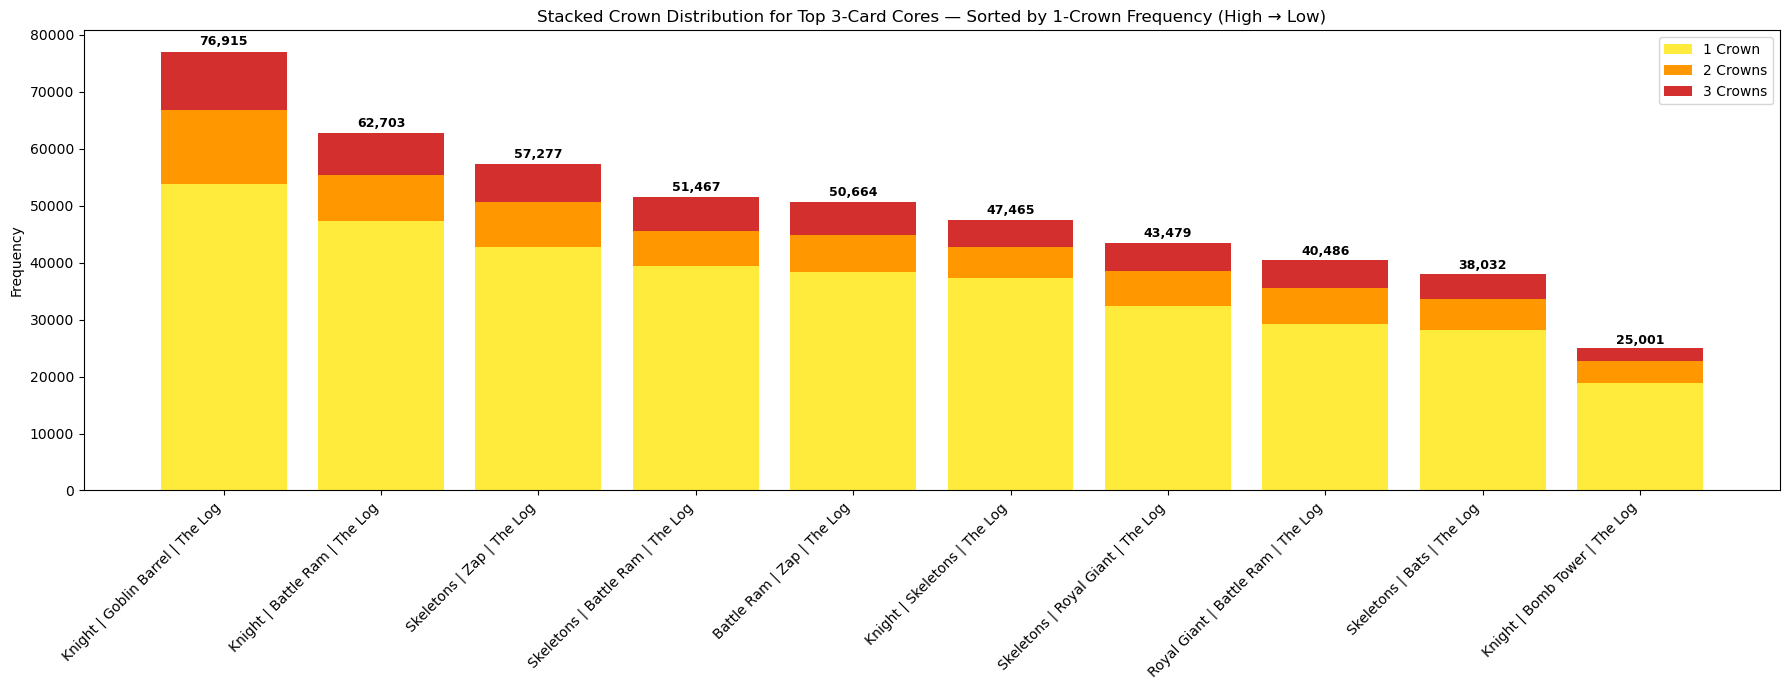

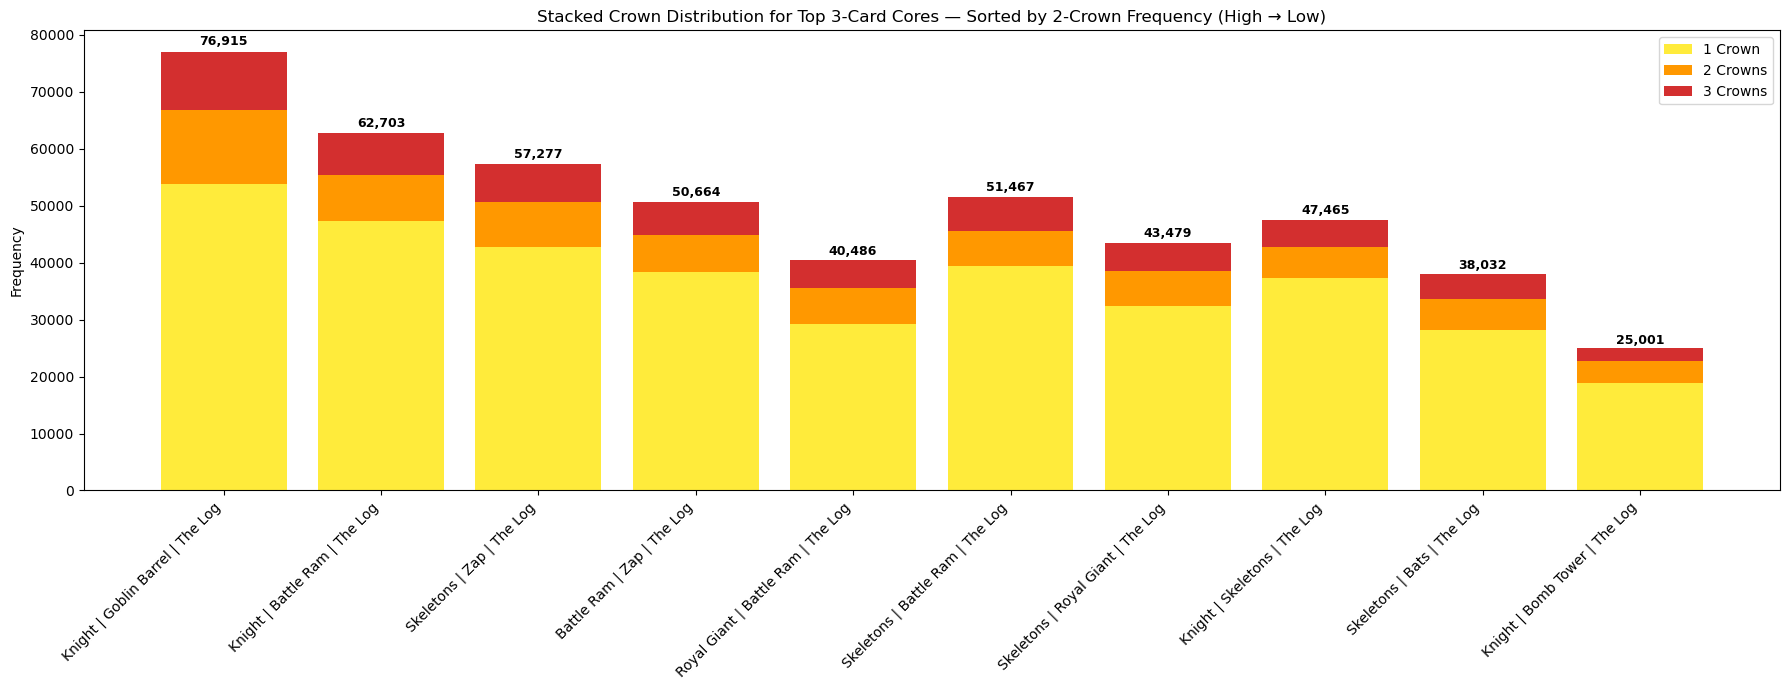

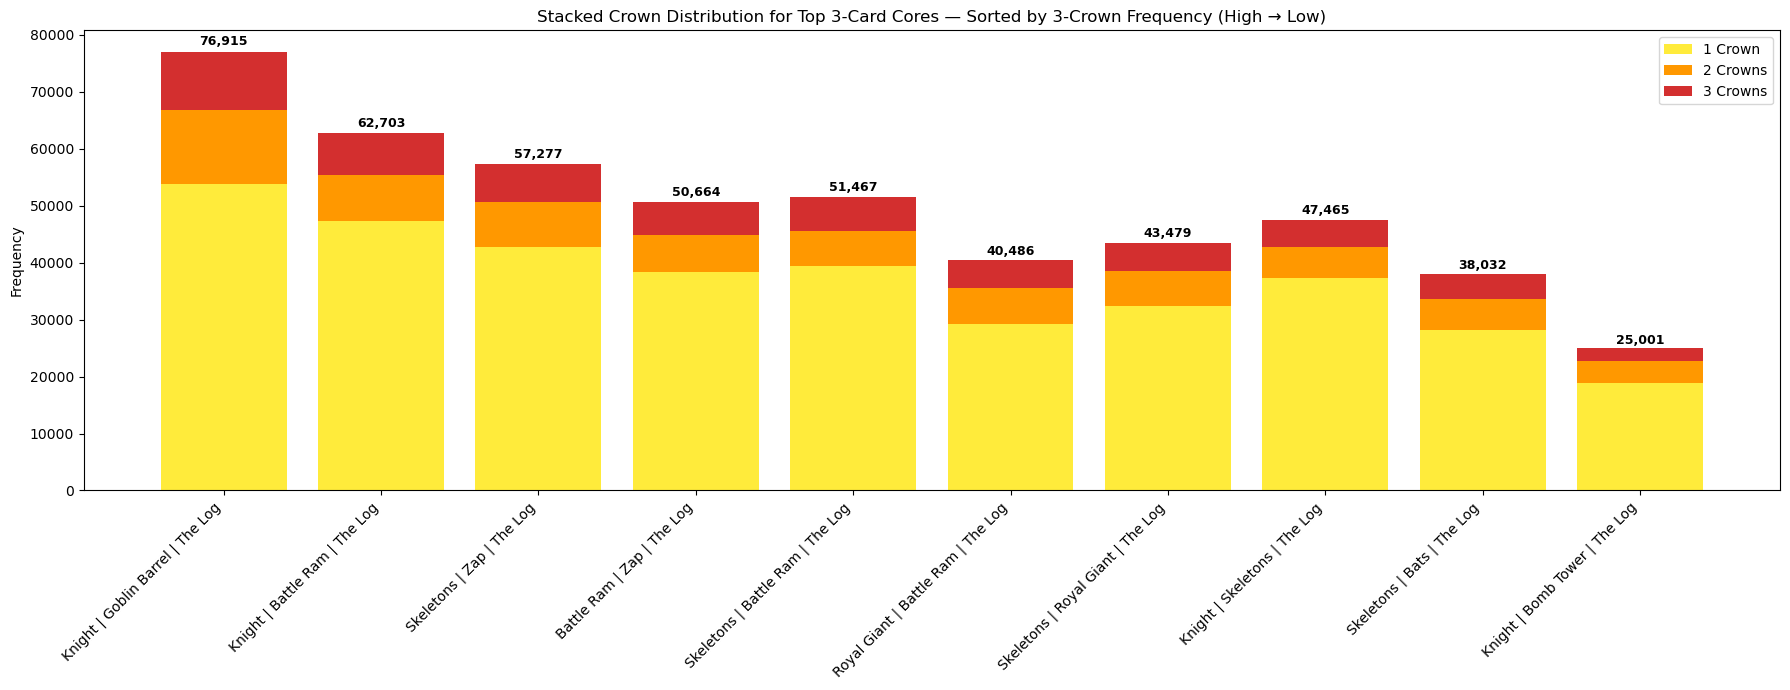

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Convert core tuple → readable label
def core_to_label(core_tuple):
    return " | ".join(id_to_name.get(cid, f"Unknown-{cid}") for cid in core_tuple)

def plot_sorted_chart(df, sort_col, title_suffix):
    # Sort
    df_sorted = df.sort_values(sort_col, ascending=False).reset_index(drop=True)

    # Labels
    core_labels = [core_to_label(c) for c in df_sorted["core"]]

    # Frequencies
    c1 = df_sorted["crown_1"].values
    c2 = df_sorted["crown_2"].values
    c3 = df_sorted["crown_3"].values

    x = np.arange(len(core_labels))

    plt.figure(figsize=(18, 7))

    # Stacked bars
    plt.bar(x, c1, label="1 Crown", color="#FFEB3B")
    plt.bar(x, c2, bottom=c1, label="2 Crowns", color="#FF9800")
    plt.bar(x, c3, bottom=c1+c2, label="3 Crowns", color="#D32F2F")

    # Total labels
    for i in range(len(x)):
        total = c1[i] + c2[i] + c3[i]
        plt.text(
            x[i], 
            total + total * 0.01,
            f"{total:,}",
            ha="center", va="bottom",
            fontsize=9, fontweight="bold"
        )

    plt.xticks(x, core_labels, rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.title(f"Stacked Crown Distribution for Top 3-Card Cores — Sorted by {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ======================================
# Produce all 3 charts
# ======================================
plot_sorted_chart(core_crown_df, "crown_1", "1-Crown Frequency (High → Low)")
plot_sorted_chart(core_crown_df, "crown_2", "2-Crown Frequency (High → Low)")
plot_sorted_chart(core_crown_df, "crown_3", "3-Crown Frequency (High → Low)")


C:\Users\peter\AppData\Local\Temp\ipykernel_692\908944734.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



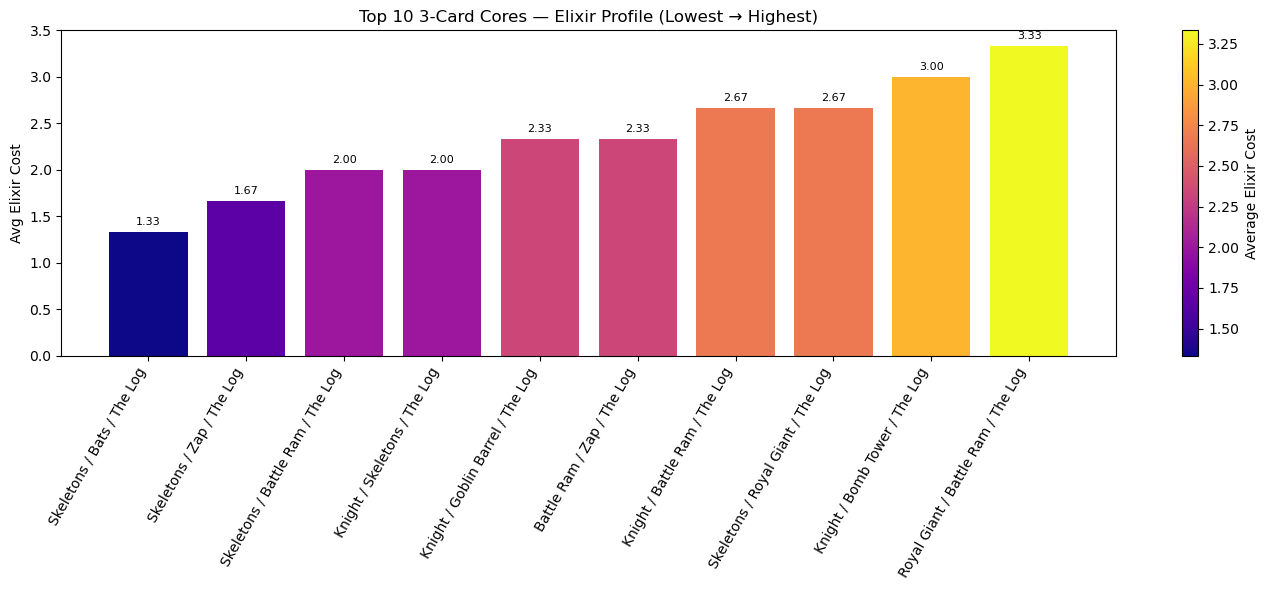

In [97]:
# -------------------------------------------------
# Sort by Elixir (ascending)
# -------------------------------------------------
core_sorted = core_top.sort_values("avg_elixir", ascending=True).copy()

# Recompute normalized color scale
elixir_norm = (core_sorted["avg_elixir"] - core_sorted["avg_elixir"].min()) / (
    core_sorted["avg_elixir"].max() - core_sorted["avg_elixir"].min()
)
colors = plt.cm.plasma(elixir_norm.values)

# -------------------------------------------------
# Plot bar chart sorted by elixir
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(core_sorted["core_label"], core_sorted["avg_elixir"], color=colors)
ax.set_xticklabels(core_sorted["core_label"], rotation=60, ha="right")
ax.set_ylabel("Avg Elixir Cost")
ax.set_title("Top 10 3-Card Cores — Elixir Profile (Lowest → Highest)")

# Numeric labels
for b, value in zip(bars, core_sorted["avg_elixir"]):
    ax.text(
        b.get_x() + b.get_width() / 2,
        value + 0.05,
        f"{value:.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Colorbar
sm = plt.cm.ScalarMappable(
    cmap="plasma",
    norm=plt.Normalize(
        vmin=core_sorted["avg_elixir"].min(),
        vmax=core_sorted["avg_elixir"].max()
    )
)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Average Elixir Cost")

plt.tight_layout()
plt.show()


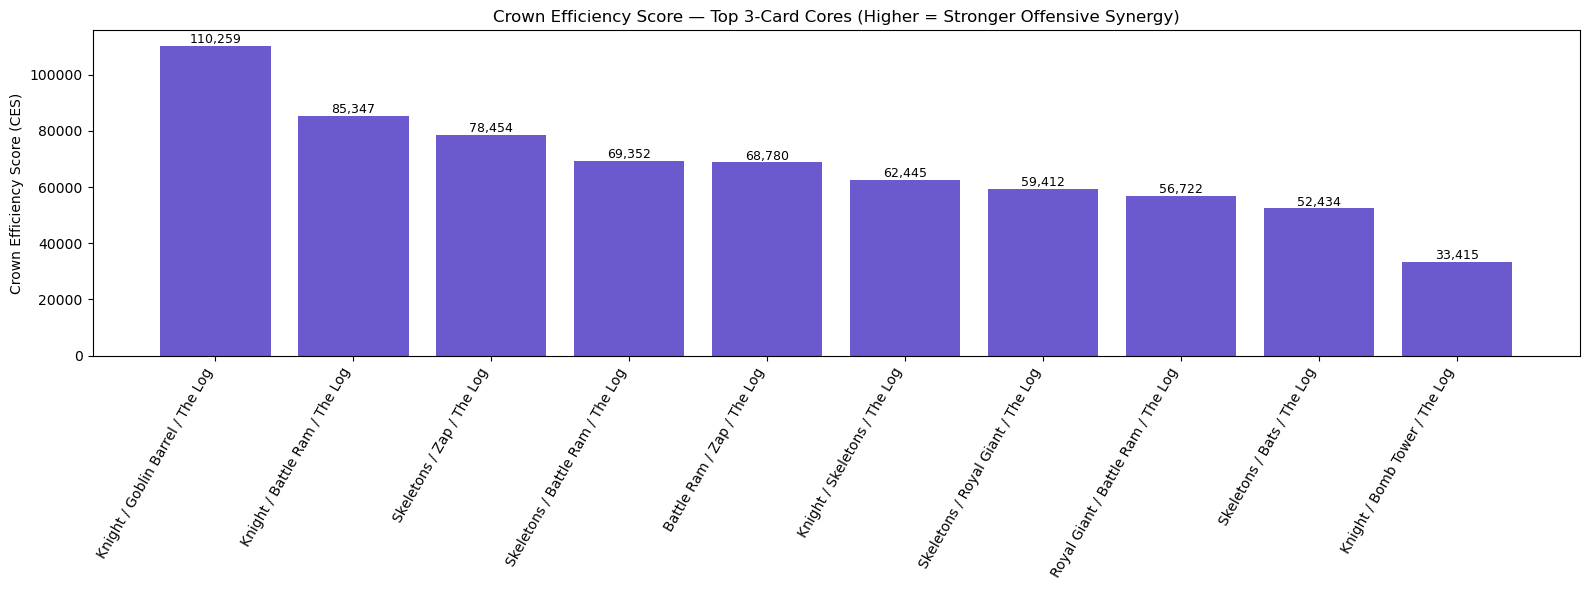

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------
# Ensure crown stats exist from last visualization
# (top10 must already contain: f1, f2, f3, core_label)
# ------------------------------------------------

if not all(col in top10.columns for col in ["f1", "f2", "f3", "label"]):
    raise ValueError("top10 must contain f1, f2, f3, and label. Run previous cell first.")

# ----------------------------------------------
# Compute Crown Efficiency Score (CES)
# ----------------------------------------------
top10["CES"] = (
    top10["f1"] * 1 +
    top10["f2"] * 2 +
    top10["f3"] * 3
)

# Sort by CES high → low
top10_sorted = top10.sort_values("CES", ascending=False)

# ----------------------------------------------
# Plot CES bar chart
# ----------------------------------------------
plt.figure(figsize=(16, 6))

bars = plt.bar(
    top10_sorted["label"],
    top10_sorted["CES"],
    color="#6A5ACD"  # slate purple
)

# Annotate values
for bar in bars:
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        y + 1000,
        f"{int(y):,}",
        ha='center',
        fontsize=9
    )

plt.xticks(rotation=60, ha="right")
plt.ylabel("Crown Efficiency Score (CES)")
plt.title("Crown Efficiency Score — Top 3-Card Cores (Higher = Stronger Offensive Synergy)")
plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------------------------------------
# 
# ---------------------------------------------------------

_____